In [1]:
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt

# Importing required libraries and setting the directory path
import os
import time
import datetime
from sklearn.model_selection import train_test_split
import matplotlib.dates as mdates

import torch
from neuralforecast import NeuralForecast
from neuralforecast.models import PatchTST, NHITS, NBEATS
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss, RMSE
from neuralforecast.tsdataset import TimeSeriesDataset
from neuralforecast.utils import AirPassengers, AirPassengersPanel, AirPassengersStatic, augment_calendar_df
from neuralforecast.utils import AirPassengersDF

from sklearn.metrics import mean_absolute_error, r2_score
import pickle

%matplotlib inline

july = os.path.join(os.getcwd(), 'datasets/bitbrains/rnd/2013-7/')
august = os.path.join(os.getcwd(), 'datasets/bitbrains/rnd/2013-8/')
septempber = os.path.join(os.getcwd(), 'datasets/bitbrains/rnd/2013-9/')

## Bitbrains PatchTST

In [2]:
def df_processing(df):

    df.columns = df.columns.str.replace('\t', '')

    df.insert(0, "DateTime", df['Timestamp [ms]'].apply(lambda x: datetime.datetime.fromtimestamp(x).replace(second=0, microsecond=0)))
    df = df.drop(columns=['Timestamp [ms]'])
    df.set_index('DateTime', inplace=True)
    df = df.sort_index()
    df = df.resample('5min').ffill()
    return df

df2_july = pd.read_csv(os.path.join(july, '383.csv'), sep=';')
df2_aug = pd.read_csv(os.path.join(august, '383.csv'), sep=';')
df2_sep = pd.read_csv(os.path.join(septempber, '383.csv'), sep=';')

df4_july = pd.read_csv(os.path.join(july, '392.csv'), sep=';')
df4_aug = pd.read_csv(os.path.join(august, '392.csv'), sep=';')
df4_sep = pd.read_csv(os.path.join(septempber, '392.csv'), sep=';')

df6_july = pd.read_csv(os.path.join(july, '386.csv'), sep=';')
df6_aug = pd.read_csv(os.path.join(august, '386.csv'), sep=';')
df6_sep = pd.read_csv(os.path.join(septempber, '386.csv'), sep=';')

dfs2_list = [df2_july, df2_aug, df2_sep]
dfs4_list = [df4_july, df4_aug, df4_sep]
dfs6_list = [df6_july, df6_aug, df6_sep]

dfs2 = [df_processing(df) for df in dfs2_list]
dfs4 = [df_processing(df) for df in dfs4_list]
dfs6 = [df_processing(df) for df in dfs6_list]

df2 = pd.concat(dfs2)
df2 = df2.bfill()
df4 = pd.concat(dfs4)
df4 = df4.bfill()
df6 = pd.concat(dfs6)
df6 = df6.bfill()

#df_list = [df2, df4, df6]
# df_list = [df_processing(df) for df in df_list]
# merged_df = pd.concat(df_list)

In [3]:
def fill_missing(df, start, end):
    df.reset_index(inplace=True)

    # Identify the previous day's period for replication
    previous_day_start = start - pd.DateOffset(days=1)
    previous_day_end = end - pd.DateOffset(days=1)

    # Filter the DataFrame to get the previous day's data
    previous_day_data = df[(df['DateTime'] >= previous_day_start) & (df['DateTime'] <= previous_day_end)]

    # Generate new timestamps for the missing period
    missing_period_timestamps = pd.date_range(start=start, end=end, freq='5min')

    # Replicate the previous day's data to the missing period
    replicated_data = previous_day_data.copy()
    replicated_data['DateTime'] = missing_period_timestamps[:len(previous_day_data)]

    # Concatenate the replicated data with the original DataFrame
    df_filled = pd.concat([df, replicated_data]).sort_values(by='DateTime').reset_index(drop=True)
    df_filled.set_index('DateTime', inplace=True)

    return df_filled

start_july = pd.to_datetime('2013-07-30 23:00:00')
end_july = pd.to_datetime('2013-07-31 23:00:00')
start_aug = pd.to_datetime('2013-08-30 23:00:00')
end_aug = pd.to_datetime('2013-08-31 23:00:00')
df2 = fill_missing(df2, start_july, end_july)
df2 = fill_missing(df2, start_aug, end_aug)
df4 = fill_missing(df4, start_july, end_july)
df4 = fill_missing(df4, start_aug, end_aug)
df6 = fill_missing(df6, start_july, end_july)
df6 = fill_missing(df6, start_aug, end_aug)

df_list = [df2, df4, df6]
merged_df = pd.concat(df_list)

In [4]:
merged_df.shape

(78624, 10)

In [5]:
merged_df = merged_df.sort_index()
df = merged_df
df = df[['CPU cores', 'CPU usage [%]']]
df = df[df.index > '2013-06-30 23:55:00']
df.reset_index(inplace=True)
df.sort_values(by=['DateTime', 'CPU cores'], inplace=True)
df.rename(columns={"CPU cores": "unique_id", "DateTime": "ds", "CPU usage [%]": "y"}, inplace=True)
df.head(12)

ds  unique_id          y
0  2013-07-01 00:00:00        2.0  17.300000
2  2013-07-01 00:00:00        4.0   9.983333
1  2013-07-01 00:00:00        6.0  40.777778
5  2013-07-01 00:05:00        2.0  20.600000
4  2013-07-01 00:05:00        4.0  27.833333
3  2013-07-01 00:05:00        6.0  41.311111
7  2013-07-01 00:10:00        2.0  17.566667
6  2013-07-01 00:10:00        4.0  50.433333
8  2013-07-01 00:10:00        6.0  37.333333
10 2013-07-01 00:15:00        2.0  18.233333
9  2013-07-01 00:15:00        4.0  39.366667
11 2013-07-01 00:15:00        6.0  41.700000

In [6]:
df.shape

(78588, 3)

In [7]:
#df_train, df_test = train_test_split(df, test_size=0.1, shuffle=False)
df_train, df_test = df[:70731], df[70731:]
df_train.shape, df_test.shape

((70731, 3), (7857, 3))

## PatchTST

In [7]:
model = PatchTST(h=6,
                 input_size=48,
                 patch_len=16,
                 stride=8,
                 #revin=True,
                 hidden_size=256,
                 linear_hidden_size=256,
                 batch_size=32,
                 encoder_layers=4,
                 #dropout=0.1,
                 n_heads=32,
                 scaler_type='identity',
                 #loss=DistributionLoss(distribution='StudentT', level=[80, 90]),
                 loss=RMSE(),
                 #res_attention=True,
                 valid_loss=RMSE(),
                 learning_rate=1e-4,
                 max_steps=1000,
                 activation='ReLU',
                 val_check_steps=50)
nf = NeuralForecast(
    models=[model],
    freq='5min'
)
nf.fit(df=df_train, val_size=7858, time_col='ds', target_col='y', id_col='unique_id')

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | RMSE              | 0      | train
1 | valid_loss   | RMSE              | 0      | train
2 | padder_train | ConstantPad1d     | 0      | train
3 | scaler       | TemporalNorm      | 0      | train
4 | model        | PatchTST_backbone | 1.6 M  | train
-----------------------------------------------------------
1.6 M     Trainable params
4         Non-trainable params
1.6 M     Total params
6.393     Total estimated model params size (MB)


Epoch 10:   0%|          | 0/1 [00:00<?, ?it/s, v_num=30845, train_loss_step=7.750, train_loss_epoch=7.750]       

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


# SAVE MODEL AT THIS POINT

check the RMSE of this model so that we use the same one OSKube framework

In [ ]:
def create_incremented_folder(base_path):
    # Get all folder names in the base path
    existing_folders = os.listdir(base_path)
    
    # Extract folders that are purely integers
    numbered_folders = [int(folder) for folder in existing_folders if folder.isdigit()]
    
    # Determine the next folder number
    next_number = max(numbered_folders) + 1 if numbered_folders else 1
    
    # Create the new folder path
    new_folder_path = os.path.join(base_path, str(next_number))
    os.makedirs(new_folder_path)

    return new_folder_path
base_path = '/home/babarali/OSKube/scheduler/patch_checkpoints/'
save_path = create_incremented_folder(base_path)
nf.save(path=save_path, overwrite=True)

In [8]:
save_path = '/home/babarali/OSKube/scheduler/patch_checkpoints/2'
nf = NeuralForecast.load(save_path)

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/common/_base_model.py:445: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  content = torc

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


In [9]:
def patchtst_pred(model, pred_length, df_train, df_test):
    all_preds = []
    num_unique_cores = 3
    iter = int(df_test.shape[0]/(pred_length*num_unique_cores))
    inf_time = []

    for i in range(iter):

        s_time = time.time()
        forecasts = model.predict(df_train)
        inf = time.time() - s_time
        inf_time.append(inf)

        all_preds.append(forecasts)
        # df_test = df_test.loc[~df_test['ds'].isin(forecasts['ds'])]
        # df_test.reset_index(inplace=True)

        test_values = df_test.loc[df_test['ds'].isin(forecasts['ds'])].reset_index(drop=True)
        # Add the corresponding test values for the next iteration
        df_train = pd.concat([df_train, test_values]).reset_index(drop=True)

    all_preds = pd.concat(all_preds).reset_index()

    return all_preds, inf_time

patchtst_preds, inf_time = patchtst_pred(nf, nf.h, df_train, df_test)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 169.85it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 209.45it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 246.39it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 149.70it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 136.13it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 210.09it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 136.39it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 111.44it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 210.43it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 138.18it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 154.24it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 138.67it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 207.91it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 130.69it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 108.98it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 209.22it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 198.69it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 205.17it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 183.16it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 51.48it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.69it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 220.81it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 181.78it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 201.80it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 162.20it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 203.62it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 100.96it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 171.74it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 162.48it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 137.97it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 201.81it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 144.97it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 115.52it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 110.56it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 223.72it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 127.32it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 182.79it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 185.35it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 135.88it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 217.24it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 127.71it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 144.58it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 158.62it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 113.50it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 178.11it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.18it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 116.48it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 194.11it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 137.84it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 155.56it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 210.47it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 164.95it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 181.68it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 144.80it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 144.49it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 152.53it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 190.57it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 164.15it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 206.69it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 143.91it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 154.91it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 137.62it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.32it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 161.99it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 129.37it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.47it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 150.93it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 174.65it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 117.83it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.84it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 163.83it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 100.89it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 134.41it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 133.20it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 196.33it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 145.01it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 160.71it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 184.47it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 105.75it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.77it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 179.83it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 176.48it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 127.60it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 173.87it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 176.58it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 157.26it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 113.70it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 174.48it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 156.90it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 101.00it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 195.10it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.85it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 155.47it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 124.10it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 110.09it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 210.77it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 98.15it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 128.60it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.15it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 214.12it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 116.42it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 144.21it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 182.69it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.67it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 201.33it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 155.74it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 117.09it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 197.72it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 175.00it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.80it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 173.10it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 167.03it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 177.15it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 104.27it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 157.86it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 125.96it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 102.74it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 102.42it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.78it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 163.92it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.73it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 224.21it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 193.48it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 180.34it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 134.67it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 178.12it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 140.52it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 179.50it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 164.72it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 148.50it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 149.06it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 107.74it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 146.12it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 151.90it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 97.37it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 95.97it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 99.92it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 172.03it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 176.20it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 163.01it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 138.12it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 106.87it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 114.96it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 181.69it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 191.13it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 197.79it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 161.82it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 198.86it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 185.45it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 102.08it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 178.57it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 118.66it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 137.72it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 184.38it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 186.45it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 150.34it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 159.47it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 195.59it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 202.39it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 113.53it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 165.47it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 139.07it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.91it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 109.74it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 102.89it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 141.92it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 190.64it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 186.71it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 128.53it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 178.33it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.67it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 60.28it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 153.61it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.32it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 97.70it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 97.01it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 153.04it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 100.43it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.26it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 174.97it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 195.12it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 179.31it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 226.45it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 145.13it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 205.56it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.92it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 121.24it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 128.58it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 181.09it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 96.39it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.77it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 104.25it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.81it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 122.32it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 204.24it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 190.43it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 181.29it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 165.57it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 180.73it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.14it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 175.58it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 130.16it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 195.02it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 207.05it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 169.36it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 114.12it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 147.54it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 159.43it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 111.62it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 187.92it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 124.22it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 135.11it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 145.27it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 176.62it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 143.41it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 191.17it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 163.58it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 189.76it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 174.69it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 131.17it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 128.73it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 170.94it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 158.84it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 143.80it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 174.02it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 130.42it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 182.27it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 97.54it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 108.35it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 141.37it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 174.37it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.72it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 165.36it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.58it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 128.89it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 173.73it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 110.50it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 109.95it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.51it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 122.18it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 107.76it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 178.72it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 140.70it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 161.84it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 106.87it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 213.06it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 212.09it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 143.68it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 174.55it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 125.40it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.66it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 191.30it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 204.86it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.74it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 198.81it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.48it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 103.41it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 217.95it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 120.60it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 103.86it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 112.20it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 164.72it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 188.02it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 180.22it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 131.03it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 102.60it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 164.07it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 218.33it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 95.47it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 153.04it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 105.27it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 167.68it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 99.62it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 204.40it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 172.97it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 141.97it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 141.24it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 100.15it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 114.14it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 163.15it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 137.29it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 180.60it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 184.17it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 193.69it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 102.52it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 125.44it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 202.30it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 207.82it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 171.03it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 154.68it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 144.10it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 95.94it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.74it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 162.03it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 174.68it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 172.22it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.75it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 192.33it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 111.02it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.25it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 186.95it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 199.55it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 110.81it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 163.12it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.75it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 123.47it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 208.12it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 105.25it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 195.93it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.76it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 129.70it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.43it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 182.43it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 202.99it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 162.56it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 198.10it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.16it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 161.09it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 136.06it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 132.43it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 184.62it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 158.20it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 99.92it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 188.32it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.46it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 103.31it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 109.98it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.57it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 107.49it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 119.95it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 120.55it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 180.52it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 120.02it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 169.82it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 95.55it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 109.44it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 192.23it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 157.46it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 201.48it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 169.75it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 119.85it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 120.01it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 164.27it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 196.29it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 175.50it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 178.47it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 156.92it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.19it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 118.88it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 190.38it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 129.06it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 185.11it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 188.00it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 178.05it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 131.04it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.19it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 123.76it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.24it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 172.86it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 226.74it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 191.02it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 131.99it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 149.76it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 170.48it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 112.48it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 198.43it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 108.97it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 202.44it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 181.38it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 168.43it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.11it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 208.59it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 207.72it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 106.87it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 161.05it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 194.98it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 103.62it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 99.53it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.03it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 163.41it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 198.50it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 173.37it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 127.02it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 167.83it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 106.42it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 128.53it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 211.47it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 111.07it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 106.05it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 202.69it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 151.85it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 134.38it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 178.98it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 170.61it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 221.93it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.22it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 65.31it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 97.04it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.70it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 173.35it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 119.85it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 202.23it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 179.93it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 117.86it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 172.10it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 169.67it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 212.10it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 184.57it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 187.96it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 158.78it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 164.48it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 101.77it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 119.20it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 180.35it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 98.39it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 203.04it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 218.21it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 177.96it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 197.32it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 167.82it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 196.00it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 203.38it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 207.79it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 202.42it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 125.02it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 177.85it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 103.40it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 135.65it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 164.53it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 167.66it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 185.46it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 96.58it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 204.21it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 206.42it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 162.82it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 203.64it/s]


/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [9]:
def patchtst_pred(model, pred_length, df_train, df_test):
    all_preds = []
    all_preds_array = []
    num_unique_cores = 3
    iter = int(df_test.shape[0] - (num_unique_cores*pred_length))
    inf_time = []

    for i in range(iter):
        print(i)
        s_time = time.time()
        forecasts = model.predict(df_train)
        inf = time.time() - s_time
        inf_time.append(inf)
        all_preds.append(forecasts)
        all_preds_array.append(forecasts['PatchTST'].values)

        next_timestep = forecasts['ds'].min()
        test_values = df_test[df_test['ds'] == next_timestep]
        
        # Append these test values to df_train for the next iteration
        df_train = pd.concat([df_train, test_values]).reset_index(drop=True)
        
        # Remove the used test values from df_test
        df_test = df_test[~df_test.index.isin(test_values.index)].reset_index(drop=True)

    return all_preds, all_preds_array, inf_time

patchtst_preds, patchtst_np, inf_time = patchtst_pred(nf, nf.h, df_train, df_test)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


0
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.31it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 109.76it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 112.57it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.49it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 95.75it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.32it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 131.59it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 95.78it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



8
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.44it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



9
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.01it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



10
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.90it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



11
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 158.46it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



12
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 100.76it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



13
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.72it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



14
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 127.91it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



15
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 132.23it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



16
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 130.41it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



17
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 140.18it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



18
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.69it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



19
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 167.82it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



20
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 165.38it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



21
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.09it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



22
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.45it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



23
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.05it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



24
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.53it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



25
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 97.25it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



26
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 105.52it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



27
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 103.15it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



28
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 108.23it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



29
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 133.23it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



30
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.24it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



31
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.66it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



32
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 98.07it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



33
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 136.80it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



34
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.85it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



35
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 111.44it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



36
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.44it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



37
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 123.48it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



38
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 58.86it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



39
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.00it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



40
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.88it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



41
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 68.56it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



42
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 68.29it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



43
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 62.08it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



44
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.19it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



45
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 161.95it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



46
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 55.39it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



47
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.43it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



48
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.81it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



49
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.95it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



50
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.68it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



51
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.90it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



52
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 44.96it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



53
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 110.85it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



54
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.76it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



55
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 48.95it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



56
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 56.70it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



57
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 68.21it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



58
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 66.24it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



59
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.53it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



60
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.67it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



61
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.44it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



62
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.34it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



63
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 132.15it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



64
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 96.52it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



65
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 114.41it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



66
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 120.37it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



67
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.56it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



68
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.79it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



69
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 145.40it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



70
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.85it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



71
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 103.16it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



72
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 117.51it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



73
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 104.21it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



74
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 123.20it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



75
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 155.08it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



76
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.37it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



77
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.72it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



78
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 103.08it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



79
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 160.39it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



80
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.45it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



81
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 116.32it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



82
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.63it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



83
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 98.73it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



84
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 155.68it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



85
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.41it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



86
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 119.10it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



87
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.68it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



88
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 116.65it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



89
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.18it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



90
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.98it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



91
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 145.91it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



92
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 147.98it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



93
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.22it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



94
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.95it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



95
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 145.70it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



96
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 108.05it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



97
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.01it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



98
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 136.50it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



99
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.27it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



100
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 99.38it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



101
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 129.51it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



102
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 106.56it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



103
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.04it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



104
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 110.28it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



105
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 144.52it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



106
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.50it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



107
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.13it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



108
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 98.97it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



109
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.52it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



110
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.14it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



111
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.36it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



112
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 100.19it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



113
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 138.40it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



114
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 67.77it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



115
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 153.17it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



116
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 100.79it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



117
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 167.02it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



118
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 105.33it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



119
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 113.01it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



120
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 116.30it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



121
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 125.03it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



122
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 150.05it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



123
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 154.88it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



124
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 109.07it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



125
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 145.02it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



126
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.63it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



127
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 108.47it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



128
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 95.67it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



129
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.12it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



130
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 133.02it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



131
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 176.74it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



132
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 173.90it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



133
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 104.37it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



134
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.62it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



135
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 113.00it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



136
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 117.57it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



137
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 126.88it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



138
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 101.13it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



139
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.31it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



140
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 101.67it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



141
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 126.08it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



142
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 143.11it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



143
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 159.72it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



144
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.25it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



145
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 167.36it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



146
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.63it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



147
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.65it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



148
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 140.78it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



149
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 122.10it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



150
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.48it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



151
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 164.59it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



152
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.02it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



153
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 133.24it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



154
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.91it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



155
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.49it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



156
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 97.94it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



157
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 102.51it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



158
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 158.07it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



159
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.73it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



160
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 95.94it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



161
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 128.83it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



162
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 67.95it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



163
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 144.95it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



164
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 113.47it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



165
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.98it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



166
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.47it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



167
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 106.70it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



168
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 120.09it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



169
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 117.33it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



170
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 116.56it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



171
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.76it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



172
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.92it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



173
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.77it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



174
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 145.60it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



175
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 98.06it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



176
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 105.28it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



177
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 66.56it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



178
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 156.97it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



179
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 130.56it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



180
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.70it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



181
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 152.37it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



182
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.63it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



183
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.32it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



184
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 121.01it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



185
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 130.82it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



186
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.63it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



187
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 160.30it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



188
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 140.56it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



189
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 96.97it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



190
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 128.63it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



191
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.67it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



192
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 99.02it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



193
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 102.49it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



194
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.98it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



195
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.42it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



196
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.03it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



197
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 122.55it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



198
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.94it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



199
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 98.05it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



200
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.46it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



201
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.79it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



202
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 106.79it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



203
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.39it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



204
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 152.75it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



205
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 124.66it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



206
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 55.22it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



207
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 151.98it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



208
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 99.10it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



209
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 125.54it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



210
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 130.57it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



211
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 114.58it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



212
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.78it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



213
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.36it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



214
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 145.59it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



215
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 60.21it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



216
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.69it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



217
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 118.50it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



218
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 157.05it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



219
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.94it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



220
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 96.21it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



221
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 102.79it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



222
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.76it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



223
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.28it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



224
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 126.36it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



225
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.73it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



226
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 154.79it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



227
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.20it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



228
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 126.75it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



229
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.61it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



230
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 158.02it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



231
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 96.09it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



232
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.39it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



233
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 161.84it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



234
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 161.74it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



235
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 155.53it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



236
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 167.95it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



237
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 110.21it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



238
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.75it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



239
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 95.88it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



240
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 106.33it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



241
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.18it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



242
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.80it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



243
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 151.04it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



244
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 96.27it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



245
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.91it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



246
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 96.52it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



247
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 148.34it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



248
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 146.51it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



249
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.25it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



250
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 106.69it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



251
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 124.08it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



252
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.64it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



253
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 140.60it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



254
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.23it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



255
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.93it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



256
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.37it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



257
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.48it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



258
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.68it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



259
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 99.49it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



260
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.49it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



261
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 103.73it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



262
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 101.33it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



263
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 138.81it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



264
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.19it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



265
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 153.86it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



266
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.66it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



267
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 156.78it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



268
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 151.41it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



269
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.93it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



270
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 100.35it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



271
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 109.15it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



272
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.85it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



273
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 118.74it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



274
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 129.11it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



275
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.39it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



276
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.13it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



277
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.97it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



278
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.76it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



279
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.14it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



280
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 121.20it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



281
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 158.07it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



282
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 99.88it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



283
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.17it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



284
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 99.16it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



285
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.19it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



286
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 111.12it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



287
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 137.24it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



288
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.55it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



289
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.43it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



290
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 144.66it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



291
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 133.35it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



292
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 136.67it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



293
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 102.59it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



294
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 160.39it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



295
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 101.87it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



296
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 150.29it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



297
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.70it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



298
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 173.23it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



299
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 137.55it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



300
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 152.47it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



301
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.81it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



302
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.30it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



303
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 138.53it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



304
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 135.91it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



305
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 161.39it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



306
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.91it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



307
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 117.83it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



308
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.72it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



309
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 97.92it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



310
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.34it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



311
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 134.03it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



312
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 164.41it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



313
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 128.07it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



314
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 114.43it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



315
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 108.91it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



316
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.52it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



317
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 161.75it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



318
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.07it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



319
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 152.73it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



320
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 121.19it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



321
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.76it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



322
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 134.12it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



323
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 149.84it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



324
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 121.81it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



325
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.14it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



326
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.59it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



327
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 122.81it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



328
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.67it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



329
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 97.06it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



330
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.88it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



331
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.42it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



332
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.05it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



333
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.57it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



334
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 160.47it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



335
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.09it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



336
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.62it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



337
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.27it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



338
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 136.13it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



339
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.03it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



340
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 106.92it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



341
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 98.40it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



342
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.81it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



343
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 152.49it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



344
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 138.85it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



345
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 154.94it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



346
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 100.82it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



347
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.70it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



348
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.37it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



349
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 96.83it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



350
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.67it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



351
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 110.13it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



352
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 109.93it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



353
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 117.21it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



354
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 99.28it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



355
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.45it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



356
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 103.05it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



357
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.21it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



358
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.51it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



359
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 123.60it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



360
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.20it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



361
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.22it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



362
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.50it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



363
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 114.79it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



364
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 129.66it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



365
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 133.13it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



366
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 112.09it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



367
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 106.71it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



368
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.95it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



369
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 144.52it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



370
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 99.62it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



371
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 117.06it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



372
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 115.25it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



373
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.51it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



374
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.09it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



375
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.97it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



376
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.32it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



377
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.82it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



378
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 131.70it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



379
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.62it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



380
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 117.89it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



381
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 146.63it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



382
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 95.91it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



383
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 109.06it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



384
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 36.43it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



385
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.76it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



386
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.41it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



387
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 98.76it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



388
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 108.40it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



389
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.72it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



390
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 135.87it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



391
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 98.09it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



392
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.31it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



393
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.03it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



394
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 143.81it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



395
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 103.93it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



396
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.46it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



397
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 97.57it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



398
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.32it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



399
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 149.59it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



400
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.98it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



401
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 104.03it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



402
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 122.09it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



403
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 128.29it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



404
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 145.82it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



405
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.12it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



406
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.51it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



407
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.16it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



408
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 107.84it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



409
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.11it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



410
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 102.58it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



411
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 117.81it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



412
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 100.51it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



413
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 154.10it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



414
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 106.87it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



415
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 146.97it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



416
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.17it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



417
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 139.58it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



418
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.48it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



419
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 98.62it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



420
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 145.12it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



421
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.43it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



422
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 141.83it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



423
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.69it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



424
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.81it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



425
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.65it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



426
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.63it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



427
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.07it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



428
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 124.89it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



429
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 141.64it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



430
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 98.28it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



431
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 151.21it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



432
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 155.21it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



433
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.92it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



434
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 121.52it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



435
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 127.12it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



436
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.35it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



437
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.21it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



438
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.50it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



439
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.74it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



440
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.36it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



441
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 101.45it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



442
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.48it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



443
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 95.59it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



444
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 147.42it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



445
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 128.99it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



446
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 111.00it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



447
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.70it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



448
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 148.63it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



449
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.88it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



450
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.75it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



451
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.45it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



452
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 155.99it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



453
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 135.36it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



454
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 133.31it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



455
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 115.90it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



456
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.86it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



457
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 131.71it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



458
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 117.70it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



459
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.22it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



460
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.31it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



461
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 171.83it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



462
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 49.71it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



463
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 98.21it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



464
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.58it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



465
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 115.00it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



466
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 95.93it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



467
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 107.69it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



468
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.59it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



469
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 174.23it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



470
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.78it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



471
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.05it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



472
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.85it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



473
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.03it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



474
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 159.56it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



475
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.47it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



476
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 101.86it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



477
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 122.12it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



478
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 148.58it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



479
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 104.95it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



480
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 131.82it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



481
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 60.63it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



482
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 122.47it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



483
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 154.83it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



484
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 113.25it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



485
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 127.79it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



486
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 100.45it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



487
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 134.22it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



488
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.51it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



489
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 159.74it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



490
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 131.44it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



491
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.78it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



492
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.80it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



493
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 96.06it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



494
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.34it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



495
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 107.87it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



496
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.84it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



497
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 162.94it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



498
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.27it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



499
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 98.37it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



500
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 95.13it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



501
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 104.18it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



502
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 127.76it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



503
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 140.80it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



504
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.96it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



505
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 106.94it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



506
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 105.52it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



507
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 153.51it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



508
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 110.79it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



509
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.71it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



510
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.90it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



511
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 120.13it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



512
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 156.58it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



513
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 135.51it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



514
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 106.93it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



515
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.47it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



516
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.37it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



517
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 108.43it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



518
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 95.56it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



519
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.09it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



520
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.44it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



521
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 96.35it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



522
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.89it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



523
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.56it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



524
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.03it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



525
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 100.98it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



526
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.54it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



527
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.39it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



528
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.54it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



529
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 129.77it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



530
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.84it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



531
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 109.10it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



532
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 158.10it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



533
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 127.39it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



534
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.20it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



535
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 116.63it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



536
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 127.59it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



537
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.66it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



538
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 110.52it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



539
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.89it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



540
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 114.12it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



541
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.47it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



542
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.44it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



543
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.27it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



544
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.01it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



545
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.83it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



546
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.43it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



547
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 113.14it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



548
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 114.97it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



549
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.29it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



550
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 98.63it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



551
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 164.55it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



552
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 99.44it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



553
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.61it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



554
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 101.04it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



555
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 133.65it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



556
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 99.72it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



557
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.54it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



558
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.69it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



559
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 147.92it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



560
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.82it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



561
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 141.57it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



562
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 66.97it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



563
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 139.09it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



564
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 141.70it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



565
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.98it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



566
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 154.70it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



567
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.98it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



568
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 61.85it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



569
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 113.48it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



570
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 113.27it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



571
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.53it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



572
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.97it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



573
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 129.83it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



574
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 148.15it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



575
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 137.13it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



576
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.07it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



577
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.15it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



578
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.42it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



579
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 119.07it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



580
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 103.47it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



581
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 99.56it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



582
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 109.30it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



583
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.44it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



584
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.95it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



585
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 151.51it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



586
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.44it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



587
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 156.37it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



588
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.86it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



589
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 111.28it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



590
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.57it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



591
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.76it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



592
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 106.46it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



593
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 96.11it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



594
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 95.57it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



595
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.28it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



596
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.74it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



597
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.65it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



598
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 105.62it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



599
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.13it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



600
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.35it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



601
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 95.24it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



602
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 122.52it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



603
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 99.82it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



604
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.84it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



605
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 119.00it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



606
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.61it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



607
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 116.69it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



608
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 171.60it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



609
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.19it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



610
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.74it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



611
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 150.58it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



612
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 117.67it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



613
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 138.53it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



614
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.67it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



615
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 97.18it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



616
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.42it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



617
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 100.63it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



618
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 98.89it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



619
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 65.99it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



620
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.50it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



621
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.84it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



622
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.23it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



623
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.36it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



624
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 128.92it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



625
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 139.11it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



626
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 145.87it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



627
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 149.38it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



628
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 115.53it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



629
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 137.03it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



630
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.21it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



631
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 98.03it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



632
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.23it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



633
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 120.70it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



634
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 161.79it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



635
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.83it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



636
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 102.48it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



637
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 107.88it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



638
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.72it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



639
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 109.19it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



640
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.95it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



641
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.65it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



642
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 105.94it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



643
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 144.19it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



644
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.26it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



645
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 153.33it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



646
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 108.16it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



647
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.08it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



648
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.14it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



649
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 95.97it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



650
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 104.09it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



651
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 154.69it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



652
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 155.24it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



653
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 145.08it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



654
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.70it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



655
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.48it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



656
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.71it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



657
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 149.17it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



658
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 100.91it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



659
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.09it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



660
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 112.78it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



661
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.63it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



662
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 66.34it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



663
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.01it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



664
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 95.23it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



665
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 67.28it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



666
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 108.46it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



667
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.29it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



668
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 124.64it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



669
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 174.12it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



670
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.70it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



671
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 148.65it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



672
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 146.67it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



673
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 97.16it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



674
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 133.36it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



675
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 124.49it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



676
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.82it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



677
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 154.29it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



678
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.04it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



679
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.67it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



680
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.63it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



681
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.80it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



682
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 118.26it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



683
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.88it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



684
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 107.22it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



685
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 102.56it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



686
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.49it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



687
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 161.16it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



688
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.63it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



689
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.17it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



690
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.82it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



691
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 95.15it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



692
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.30it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



693
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.42it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



694
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 130.39it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



695
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 148.06it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



696
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.09it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



697
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 145.60it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



698
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 135.06it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



699
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 107.92it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



700
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 136.98it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



701
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 138.84it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



702
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 98.46it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



703
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.75it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



704
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 101.10it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



705
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 102.42it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



706
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 98.09it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



707
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 135.64it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



708
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.55it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



709
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 98.82it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



710
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 127.42it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



711
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 159.40it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



712
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 118.62it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



713
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 122.68it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



714
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 143.67it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



715
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.09it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



716
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.77it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



717
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 143.67it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



718
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 95.66it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



719
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 109.97it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



720
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.73it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



721
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.86it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



722
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.09it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



723
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 101.41it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



724
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 117.26it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



725
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 159.75it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



726
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.40it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



727
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.61it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



728
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 102.36it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



729
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 161.77it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



730
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.79it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



731
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 99.79it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



732
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.30it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



733
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.83it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



734
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.84it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



735
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.45it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



736
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.74it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



737
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 150.97it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



738
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 104.60it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



739
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.69it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



740
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.40it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



741
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 143.61it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



742
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 120.28it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



743
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.39it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



744
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 60.76it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



745
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 123.87it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



746
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.94it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



747
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 127.14it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



748
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 163.78it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



749
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 110.72it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



750
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 164.74it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



751
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 63.52it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



752
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.38it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



753
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 135.20it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



754
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 168.54it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



755
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 108.89it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



756
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.52it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



757
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 116.43it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



758
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.37it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



759
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.22it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



760
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 98.46it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



761
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.79it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



762
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 59.53it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



763
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.92it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



764
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 117.59it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



765
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 101.68it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



766
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 113.25it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



767
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 126.30it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



768
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 108.03it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



769
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.96it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



770
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 114.98it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



771
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.01it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



772
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.72it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



773
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.26it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



774
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 141.07it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



775
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 125.36it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



776
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 98.84it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



777
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 154.93it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



778
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.46it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



779
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 119.69it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



780
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 146.54it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



781
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.57it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



782
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 145.66it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



783
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 103.01it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



784
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 117.50it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



785
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 158.35it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



786
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.21it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



787
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.61it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



788
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 126.89it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



789
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 124.93it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



790
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.60it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



791
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 103.71it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



792
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 148.89it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



793
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.85it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



794
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.34it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



795
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 112.14it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



796
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 128.99it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



797
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 128.56it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



798
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.93it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



799
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.19it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



800
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.95it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



801
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 165.91it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



802
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 146.22it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



803
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.34it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



804
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.74it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



805
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 113.44it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



806
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.98it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



807
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 123.83it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



808
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 95.21it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



809
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.05it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



810
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.08it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



811
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 111.17it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



812
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.15it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



813
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.12it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



814
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 96.38it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



815
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.60it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



816
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.18it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



817
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.84it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



818
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 113.37it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



819
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 100.05it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



820
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.75it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



821
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 161.95it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



822
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 109.22it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



823
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 100.54it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



824
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.30it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



825
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 111.67it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



826
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 139.97it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



827
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 145.48it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



828
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 99.37it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



829
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.33it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



830
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 179.90it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



831
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 141.53it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



832
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 115.98it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



833
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 154.32it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



834
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.50it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



835
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.81it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



836
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 160.69it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



837
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.30it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



838
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.30it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



839
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 104.77it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



840
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 154.70it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



841
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 110.90it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



842
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 140.48it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



843
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.65it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



844
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.40it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



845
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 96.49it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



846
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.86it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



847
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 108.30it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



848
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 136.23it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



849
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 139.75it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



850
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 95.24it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



851
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.45it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



852
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 159.21it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



853
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.42it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



854
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 132.96it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



855
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.64it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



856
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 68.48it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



857
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.68it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



858
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.16it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



859
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 143.66it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



860
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 134.18it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



861
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 135.62it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



862
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 157.27it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



863
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 151.30it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



864
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 136.97it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



865
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 124.35it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



866
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.60it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



867
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.59it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



868
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 109.76it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



869
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 163.94it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



870
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 128.22it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



871
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.05it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



872
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 119.09it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



873
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.58it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



874
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.21it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



875
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 105.90it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



876
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.72it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



877
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.66it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



878
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 155.67it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



879
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 97.38it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



880
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 134.93it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



881
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.58it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



882
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 120.73it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



883
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 119.54it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



884
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.13it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



885
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.71it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



886
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 136.15it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



887
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 121.87it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



888
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.30it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



889
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.23it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



890
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 98.29it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



891
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 131.93it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



892
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 146.86it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



893
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 131.55it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



894
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 140.75it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



895
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 97.68it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



896
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.15it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



897
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.27it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



898
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.23it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



899
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.27it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



900
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 103.03it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



901
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 95.77it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



902
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 122.63it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



903
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 107.93it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



904
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.45it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



905
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.90it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



906
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.52it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



907
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 109.82it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



908
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.17it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



909
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 109.12it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



910
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 106.62it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



911
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.94it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



912
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.07it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



913
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.27it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



914
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 132.99it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



915
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 145.65it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



916
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 132.16it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



917
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 130.32it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



918
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 95.64it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



919
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 102.26it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



920
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.92it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



921
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 148.22it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



922
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.23it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



923
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.17it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



924
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.02it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



925
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.78it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



926
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.28it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



927
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 125.81it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



928
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 144.62it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



929
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.28it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



930
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.78it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



931
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.65it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



932
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 126.70it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



933
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 59.75it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



934
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 124.25it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



935
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 111.81it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



936
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 111.51it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



937
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 149.33it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



938
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 108.18it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



939
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 98.65it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



940
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 154.04it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



941
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 108.53it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



942
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.64it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



943
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.63it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



944
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.19it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



945
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.12it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



946
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.26it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



947
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.47it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



948
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.93it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



949
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 155.47it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



950
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 144.14it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



951
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 65.64it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



952
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 137.80it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



953
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 162.12it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



954
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 102.38it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



955
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.77it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



956
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.31it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



957
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 109.22it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



958
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.32it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



959
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 155.86it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



960
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.56it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



961
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 127.15it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



962
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.83it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



963
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 149.49it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



964
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 115.33it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



965
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 102.56it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



966
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.53it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



967
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.07it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



968
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 106.14it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



969
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.35it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



970
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 100.73it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



971
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.82it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



972
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.19it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



973
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 111.20it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



974
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.42it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



975
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.79it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



976
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 97.44it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



977
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 114.48it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



978
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 160.93it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



979
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.40it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



980
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 140.69it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



981
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.74it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



982
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 127.53it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



983
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 149.79it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



984
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.90it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



985
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 145.81it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



986
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 111.34it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



987
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.90it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



988
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.16it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



989
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 149.56it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



990
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 128.55it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



991
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 95.53it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



992
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 101.60it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



993
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.54it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



994
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 151.82it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



995
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 144.02it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



996
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 141.24it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



997
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 111.30it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



998
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 126.63it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



999
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.23it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1000
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.01it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1001
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 100.52it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1002
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.28it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1003
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 138.55it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1004
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.00it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1005
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.04it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1006
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.38it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1007
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 133.35it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1008
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.86it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1009
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 153.94it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1010
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 151.29it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1011
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.50it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1012
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.08it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1013
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 95.91it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1014
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 117.35it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1015
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.06it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1016
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.51it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1017
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 133.58it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1018
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.09it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1019
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.57it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1020
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 126.36it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1021
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 119.71it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1022
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.27it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1023
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.27it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1024
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.98it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1025
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 145.46it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1026
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 101.20it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1027
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.63it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1028
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 116.53it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1029
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 99.04it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1030
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 119.51it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1031
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.23it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1032
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.32it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1033
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 125.41it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1034
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 119.44it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1035
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.22it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1036
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.87it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1037
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 162.31it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1038
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.88it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1039
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 128.57it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1040
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.87it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1041
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.42it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1042
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 163.10it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1043
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 118.57it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1044
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.72it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1045
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.39it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1046
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 96.75it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1047
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 133.61it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1048
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.29it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1049
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.90it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1050
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 146.04it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1051
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 96.48it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1052
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.82it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1053
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.38it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1054
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.03it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1055
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 134.74it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1056
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.96it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1057
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 149.27it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1058
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.80it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1059
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 125.70it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1060
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.58it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1061
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 138.33it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1062
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.05it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1063
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.86it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1064
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 131.71it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1065
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 140.21it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1066
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 59.67it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1067
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 126.35it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1068
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.47it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1069
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.60it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1070
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 99.91it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1071
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 101.16it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1072
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 155.44it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1073
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.86it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1074
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 110.11it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1075
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 96.46it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1076
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.84it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1077
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 100.19it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1078
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.56it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1079
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.56it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1080
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.23it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1081
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.95it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1082
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.45it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1083
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.68it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1084
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.84it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1085
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.30it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1086
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.60it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1087
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.93it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1088
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 124.40it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1089
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 131.06it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1090
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.90it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1091
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.90it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1092
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 96.44it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1093
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 131.08it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1094
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.41it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1095
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.53it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1096
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.80it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1097
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.86it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1098
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 148.82it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1099
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.63it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1100
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.07it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1101
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.43it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1102
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 133.36it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1103
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 140.23it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1104
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.63it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1105
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 113.90it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1106
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.15it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1107
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 110.66it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1108
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 99.80it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1109
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 124.93it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1110
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 158.16it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1111
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 131.11it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1112
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.72it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1113
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.53it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1114
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 159.99it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1115
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 131.08it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1116
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 153.67it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1117
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 138.74it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1118
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 133.62it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1119
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.68it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1120
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.99it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1121
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.11it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1122
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 101.38it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1123
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 155.82it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1124
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.53it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1125
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 127.94it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1126
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 68.12it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1127
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 122.66it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1128
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.73it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1129
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.96it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1130
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 132.92it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1131
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.16it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1132
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.25it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1133
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.89it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1134
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.31it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1135
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.58it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1136
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 98.11it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1137
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.04it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1138
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 139.61it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1139
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 97.20it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1140
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.35it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1141
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.18it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1142
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.25it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1143
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.91it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1144
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 156.98it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1145
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.67it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1146
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 122.32it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1147
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.59it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1148
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 102.73it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1149
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.90it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1150
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 113.54it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1151
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.78it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1152
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.97it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1153
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 108.10it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1154
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 112.37it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1155
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.16it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1156
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 98.40it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1157
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.77it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1158
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 105.50it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1159
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 146.58it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1160
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.93it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1161
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 135.98it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1162
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 107.50it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1163
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 99.48it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1164
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.47it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1165
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.24it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1166
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 136.19it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1167
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 146.11it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1168
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.95it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1169
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.87it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1170
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 106.22it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1171
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.13it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1172
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 147.08it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1173
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.19it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1174
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 144.08it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1175
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 115.34it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1176
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 159.70it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1177
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 114.93it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1178
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.57it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1179
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 107.59it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1180
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.44it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1181
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.30it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1182
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.51it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1183
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 132.54it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1184
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.53it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1185
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.70it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1186
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.58it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1187
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 68.99it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1188
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 106.74it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1189
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.13it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1190
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 143.26it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1191
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 106.51it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1192
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 146.15it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1193
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 134.70it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1194
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 177.14it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1195
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 139.36it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1196
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 141.54it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1197
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 105.64it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1198
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 42.65it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1199
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.12it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1200
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 113.94it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1201
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 138.27it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1202
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.57it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1203
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 137.45it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1204
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.68it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1205
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.92it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1206
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 167.95it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1207
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 151.81it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1208
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 143.20it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1209
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 143.05it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1210
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 51.85it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1211
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.61it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1212
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.75it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1213
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.39it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1214
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.42it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1215
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.19it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1216
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 100.22it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1217
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 115.05it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1218
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.31it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1219
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.47it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1220
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 134.83it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1221
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.71it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1222
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 110.31it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1223
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 133.96it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1224
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 152.79it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1225
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.83it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1226
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.11it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1227
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.92it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1228
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 95.37it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1229
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 132.71it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1230
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.77it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1231
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.51it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1232
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.93it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1233
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.83it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1234
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 143.93it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1235
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 97.68it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1236
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.94it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1237
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 99.65it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1238
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 106.96it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1239
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.67it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1240
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.55it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1241
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.84it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1242
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.53it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1243
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 126.05it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1244
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.90it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1245
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.01it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1246
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.04it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1247
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.64it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1248
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.37it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1249
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 131.05it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1250
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 101.27it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1251
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.35it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1252
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.98it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1253
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.04it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1254
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.28it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1255
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.27it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1256
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 96.96it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1257
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.24it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1258
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.17it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1259
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 112.40it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1260
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.41it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1261
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.66it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1262
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 112.76it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1263
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 116.89it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1264
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 157.13it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1265
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.01it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1266
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 97.10it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1267
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 153.25it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1268
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 154.29it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1269
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 103.34it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1270
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 97.31it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1271
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 104.29it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1272
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 101.75it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1273
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.84it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1274
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.04it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1275
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.77it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1276
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 105.49it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1277
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 105.57it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1278
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.60it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1279
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.27it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1280
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.71it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1281
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.09it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1282
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 130.34it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1283
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.63it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1284
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.52it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1285
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 118.43it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1286
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.90it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1287
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 66.90it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1288
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.58it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1289
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.72it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1290
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.54it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1291
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 143.43it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1292
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.89it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1293
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.62it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1294
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 129.23it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1295
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.81it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1296
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 139.06it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1297
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 116.24it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1298
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.17it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1299
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.99it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1300
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.76it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1301
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 65.30it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1302
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.47it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1303
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 117.99it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1304
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.81it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1305
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.12it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1306
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 117.82it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1307
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 102.80it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1308
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 122.23it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1309
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 116.50it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1310
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 107.15it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1311
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.92it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1312
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 140.84it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1313
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 155.02it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1314
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 136.23it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1315
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.01it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1316
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 126.09it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1317
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 134.17it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1318
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 120.71it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1319
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.47it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1320
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 118.93it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1321
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.46it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1322
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.61it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1323
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 147.45it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1324
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.51it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1325
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 140.51it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1326
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 113.45it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1327
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 146.81it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1328
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.93it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1329
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 43.48it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1330
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.72it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1331
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.65it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1332
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 109.01it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1333
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 149.72it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1334
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 96.08it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1335
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 132.01it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1336
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.18it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1337
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.17it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1338
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 97.68it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1339
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 131.29it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1340
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 145.62it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1341
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 106.70it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1342
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 163.12it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1343
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 112.83it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1344
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 132.69it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1345
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 135.70it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1346
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.47it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1347
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 109.42it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1348
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 154.97it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1349
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 103.31it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1350
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.47it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1351
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 119.76it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1352
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.48it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1353
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.91it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1354
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.83it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1355
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 106.38it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1356
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 45.09it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1357
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 122.10it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1358
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.35it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1359
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 128.93it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1360
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.46it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1361
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 135.71it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1362
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.17it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1363
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.70it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1364
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.76it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1365
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.82it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1366
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.30it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1367
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.71it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1368
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 140.89it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1369
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 107.66it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1370
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.21it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1371
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 150.05it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1372
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 152.76it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1373
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.27it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1374
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 96.38it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1375
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.35it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1376
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 115.26it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1377
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 150.03it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1378
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 136.12it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1379
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 100.06it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1380
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.76it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1381
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 109.09it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1382
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.45it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1383
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 113.10it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1384
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.25it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1385
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 119.23it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1386
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 141.89it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1387
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.70it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1388
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 126.92it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1389
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 112.58it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1390
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 141.15it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1391
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.92it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1392
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 104.60it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1393
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.25it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1394
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 104.25it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1395
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.35it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1396
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.71it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1397
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.28it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1398
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.58it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1399
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 161.30it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1400
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 134.65it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1401
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 147.70it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1402
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.59it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1403
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.05it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1404
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.00it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1405
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 130.26it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1406
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.86it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1407
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 172.63it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1408
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.22it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1409
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 106.92it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1410
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.96it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1411
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 159.00it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1412
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.44it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1413
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 139.11it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1414
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 111.69it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1415
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.43it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1416
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 109.66it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1417
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 145.46it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1418
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.26it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1419
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.83it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1420
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.09it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1421
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 114.28it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1422
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.02it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1423
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 146.13it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1424
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 109.98it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1425
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.85it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1426
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.26it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1427
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 118.56it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1428
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.30it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1429
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 118.97it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1430
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 67.48it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1431
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.97it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1432
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.42it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1433
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.89it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1434
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.75it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1435
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 135.97it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1436
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 102.98it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1437
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.95it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1438
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 146.33it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1439
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.78it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1440
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 100.81it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1441
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.71it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1442
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.56it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1443
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 102.34it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1444
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.33it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1445
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.82it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1446
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 121.03it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1447
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.95it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1448
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 141.20it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1449
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.53it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1450
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 167.84it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1451
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.58it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1452
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 133.43it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1453
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.72it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1454
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 102.98it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1455
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 111.71it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1456
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.29it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1457
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.31it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1458
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.21it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1459
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.53it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1460
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.05it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1461
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 145.36it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1462
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 97.30it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1463
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.35it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1464
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.70it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1465
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.00it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1466
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.15it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1467
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.32it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1468
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 109.08it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1469
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 137.40it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1470
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.41it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1471
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 95.49it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1472
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.35it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1473
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 136.28it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1474
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 163.00it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1475
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 95.21it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1476
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 123.68it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1477
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 172.56it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1478
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.67it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1479
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 100.51it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1480
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 109.06it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1481
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.40it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1482
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.99it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1483
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.55it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1484
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.06it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1485
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.86it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1486
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 134.60it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1487
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.19it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1488
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.35it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1489
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 121.88it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1490
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 104.02it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1491
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 150.89it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1492
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 125.51it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1493
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 95.83it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1494
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 109.89it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1495
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.44it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1496
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 105.19it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1497
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.11it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1498
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.66it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1499
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 127.94it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1500
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.56it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1501
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.91it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1502
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.70it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1503
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.40it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1504
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.65it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1505
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 135.98it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1506
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 67.96it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1507
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.91it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1508
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 165.69it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1509
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 117.40it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1510
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.57it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1511
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.43it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1512
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.24it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1513
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 164.31it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1514
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.87it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1515
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.76it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1516
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 110.89it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1517
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.73it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1518
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.12it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1519
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 125.23it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1520
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 145.21it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1521
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.37it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1522
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 96.23it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1523
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.93it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1524
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.80it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1525
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.03it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1526
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 126.48it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1527
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.37it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1528
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 98.99it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1529
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 152.23it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1530
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.58it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1531
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 151.05it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1532
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.24it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1533
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 107.54it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1534
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.24it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1535
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 113.06it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1536
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.33it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1537
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 129.06it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1538
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 150.87it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1539
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.25it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1540
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 152.35it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1541
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.01it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1542
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 154.71it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1543
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.61it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1544
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 114.68it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1545
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 149.06it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1546
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.71it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1547
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.55it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1548
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.69it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1549
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.55it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1550
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.04it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1551
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.24it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1552
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 97.57it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1553
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 125.67it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1554
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 106.07it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1555
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 138.07it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1556
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.76it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1557
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 120.58it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1558
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.78it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1559
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.46it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1560
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 100.97it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1561
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 104.16it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1562
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.16it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1563
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.74it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1564
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.02it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1565
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 108.73it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1566
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 127.63it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1567
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.67it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1568
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 96.08it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1569
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.66it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1570
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.35it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1571
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 141.11it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1572
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 119.25it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1573
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 117.17it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1574
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.20it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1575
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.04it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1576
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.27it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1577
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 153.85it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1578
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.81it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1579
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.19it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1580
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 163.73it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1581
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 125.96it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1582
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.47it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1583
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.03it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1584
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.30it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1585
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 156.63it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1586
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 112.31it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1587
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 135.47it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1588
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.22it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1589
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.12it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1590
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 112.71it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1591
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 117.22it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1592
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.65it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1593
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 111.13it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1594
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 120.56it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1595
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.41it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1596
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.17it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1597
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.53it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1598
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 111.24it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1599
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 137.82it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1600
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.66it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1601
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 110.69it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1602
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.55it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1603
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.54it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1604
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 105.10it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1605
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 117.65it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1606
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.43it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1607
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 118.59it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1608
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 107.44it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1609
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 148.04it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1610
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.59it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1611
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.12it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1612
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.76it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1613
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.90it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1614
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 150.57it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1615
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 134.10it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1616
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.38it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1617
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 140.00it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1618
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 114.98it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1619
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.25it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1620
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.44it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1621
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.82it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1622
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.64it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1623
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 129.54it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1624
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.77it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1625
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 106.78it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1626
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 151.08it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1627
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 62.90it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1628
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 130.74it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1629
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 123.55it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1630
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.24it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1631
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.17it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1632
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.98it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1633
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.71it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1634
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 108.48it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1635
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.18it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1636
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 148.30it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1637
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 143.62it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1638
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 167.53it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1639
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.21it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1640
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.39it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1641
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.61it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1642
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 125.92it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1643
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 68.61it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1644
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 144.43it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1645
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 146.14it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1646
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 96.08it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1647
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.98it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1648
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.57it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1649
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 109.22it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1650
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 137.92it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1651
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 111.34it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1652
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 106.01it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1653
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.90it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1654
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 127.39it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1655
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.86it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1656
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 125.44it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1657
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 120.93it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1658
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.43it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1659
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.32it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1660
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.22it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1661
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.18it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1662
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.17it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1663
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 154.85it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1664
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 163.72it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1665
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 120.03it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1666
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.08it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1667
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 136.42it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1668
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 133.97it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1669
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.05it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1670
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 135.02it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1671
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.94it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1672
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 99.58it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1673
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.31it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1674
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 133.23it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1675
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 140.47it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1676
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 105.30it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1677
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 124.49it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1678
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 156.12it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1679
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.47it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1680
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.16it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1681
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 130.71it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1682
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.05it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1683
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 68.74it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1684
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 102.22it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1685
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 132.00it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1686
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 159.32it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1687
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.43it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1688
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 103.79it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1689
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.84it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1690
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 103.74it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1691
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 99.38it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1692
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.52it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1693
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.24it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1694
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.48it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1695
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.46it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1696
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.20it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1697
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 154.37it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1698
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.69it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1699
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.59it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1700
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.65it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1701
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 116.04it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1702
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 104.23it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1703
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.98it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1704
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.91it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1705
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 138.64it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1706
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 64.54it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1707
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 65.44it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1708
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 100.72it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1709
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 138.52it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1710
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 158.89it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1711
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.99it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1712
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.31it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1713
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 97.50it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1714
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 146.16it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1715
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 147.85it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1716
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.10it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1717
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.87it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1718
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.19it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1719
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 98.99it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1720
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 101.90it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1721
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.55it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1722
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.83it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1723
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.84it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1724
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.50it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1725
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.41it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1726
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 124.43it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1727
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 105.59it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1728
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.27it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1729
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 100.40it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1730
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 135.81it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1731
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 156.90it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1732
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 139.42it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1733
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.70it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1734
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.31it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1735
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 146.23it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1736
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.24it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1737
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.77it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1738
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.78it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1739
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 100.56it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1740
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.30it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1741
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 106.00it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1742
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 105.47it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1743
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 107.71it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1744
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 114.11it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1745
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 114.55it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1746
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.47it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1747
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 105.42it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1748
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 102.35it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1749
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.74it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1750
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 153.64it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1751
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 103.67it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1752
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.86it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1753
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.51it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1754
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 133.17it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1755
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 105.45it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1756
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 153.64it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1757
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.94it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1758
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.57it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1759
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 56.75it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1760
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 122.37it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1761
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 119.87it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1762
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 152.52it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1763
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 147.15it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1764
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.27it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1765
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.12it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1766
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 139.39it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1767
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 159.11it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1768
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 102.58it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1769
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 107.54it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1770
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 119.35it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1771
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 97.60it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1772
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 118.48it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1773
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 123.99it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1774
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.56it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1775
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.93it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1776
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.73it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1777
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 96.23it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1778
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.91it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1779
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.43it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1780
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.17it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1781
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.32it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1782
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.15it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1783
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.36it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1784
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.10it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1785
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.38it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1786
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.73it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1787
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 132.89it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1788
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.03it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1789
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 113.56it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1790
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.53it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1791
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 146.69it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1792
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.14it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1793
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 116.32it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1794
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.42it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1795
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.71it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1796
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 148.87it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1797
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 110.19it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1798
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 67.69it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1799
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 95.37it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1800
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.68it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1801
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.24it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1802
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.63it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1803
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.24it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1804
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.81it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1805
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 151.93it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1806
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.58it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1807
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 67.14it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1808
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 99.07it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1809
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.47it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1810
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 127.82it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1811
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.88it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1812
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 159.70it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1813
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.92it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1814
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 117.77it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1815
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 132.92it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1816
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.41it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1817
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.77it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1818
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.13it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1819
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 114.54it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1820
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 119.69it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1821
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.14it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1822
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.07it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1823
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.33it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1824
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 150.70it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1825
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.66it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1826
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 127.30it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1827
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 121.72it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1828
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 169.08it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1829
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 131.17it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1830
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 155.32it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1831
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.15it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1832
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.47it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1833
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.02it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1834
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 124.25it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1835
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.51it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1836
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 107.37it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1837
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.39it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1838
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.95it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1839
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 117.43it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1840
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 110.55it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1841
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.69it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1842
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 66.40it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1843
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.93it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1844
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 127.37it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1845
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 100.22it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1846
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 143.14it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1847
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 137.01it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1848
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 104.32it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1849
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.13it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1850
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 122.61it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1851
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.66it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1852
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 154.54it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1853
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 137.67it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1854
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.48it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1855
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 127.27it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1856
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 115.68it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1857
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 68.95it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1858
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 151.62it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1859
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.94it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1860
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 118.26it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1861
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.35it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1862
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.50it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1863
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 105.45it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1864
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.90it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1865
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.10it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1866
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 140.65it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1867
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 132.12it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1868
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 156.35it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1869
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 119.48it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1870
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.91it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1871
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.84it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1872
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 111.12it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1873
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.16it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1874
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 129.62it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1875
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 121.52it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1876
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.28it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1877
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.55it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1878
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.10it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1879
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.78it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1880
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.26it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1881
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 153.98it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1882
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 129.45it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1883
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 130.67it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1884
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 140.69it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1885
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.17it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1886
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.52it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1887
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 140.15it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1888
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 98.83it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1889
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 147.69it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1890
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.45it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1891
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.33it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1892
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.43it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1893
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.05it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1894
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 62.93it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1895
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.01it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1896
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 159.99it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1897
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 98.46it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1898
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.07it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1899
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.67it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1900
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.32it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1901
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 115.50it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1902
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.34it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1903
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.90it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1904
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 128.09it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1905
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.42it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1906
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 144.21it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1907
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 155.22it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1908
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 156.06it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1909
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 100.69it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1910
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 98.75it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1911
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.58it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1912
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.41it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1913
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.73it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1914
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 165.91it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1915
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 147.23it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1916
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 98.76it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1917
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.54it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1918
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.53it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1919
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 137.28it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1920
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.20it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1921
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.61it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1922
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.65it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1923
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 101.83it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1924
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 68.82it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1925
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 130.55it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1926
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 120.43it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1927
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.09it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1928
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.53it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1929
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.41it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1930
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 96.66it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1931
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 123.04it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1932
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.55it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1933
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.47it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1934
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.28it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1935
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 96.03it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1936
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 162.31it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1937
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 106.31it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1938
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.92it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1939
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 106.42it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1940
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 145.18it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1941
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.31it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1942
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.11it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1943
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 97.07it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1944
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.54it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1945
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 126.36it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1946
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 124.65it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1947
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 135.46it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1948
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.42it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1949
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 66.23it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1950
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.40it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1951
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 97.26it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1952
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 99.40it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1953
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 144.78it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1954
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.23it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1955
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.59it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1956
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 139.65it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1957
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 135.95it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1958
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 143.73it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1959
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 67.46it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1960
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 114.05it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1961
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 122.93it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1962
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 131.36it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1963
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 119.40it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1964
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 152.34it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1965
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.21it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1966
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 131.47it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1967
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.89it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1968
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 131.61it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1969
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 98.36it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1970
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 102.23it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1971
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.01it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1972
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 106.31it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1973
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.91it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1974
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 107.98it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1975
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.94it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1976
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 115.60it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1977
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.35it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1978
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.10it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1979
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.76it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1980
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.66it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1981
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 68.49it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1982
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.55it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1983
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.78it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1984
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 134.97it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1985
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 105.90it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1986
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.94it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1987
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.71it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1988
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 64.36it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1989
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 123.29it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1990
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.65it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1991
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 103.31it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1992
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 99.17it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1993
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.25it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1994
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 118.06it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1995
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.54it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1996
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 98.76it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1997
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.15it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1998
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.14it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



1999
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.32it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2000
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 111.94it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2001
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.60it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2002
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.05it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2003
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 152.04it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2004
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 121.96it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2005
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.42it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2006
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.39it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2007
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.57it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2008
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 123.70it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2009
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.04it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2010
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.15it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2011
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.04it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2012
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 66.33it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2013
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 130.80it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2014
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.86it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2015
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.46it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2016
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 119.78it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2017
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.52it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2018
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.18it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2019
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.66it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2020
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.91it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2021
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.58it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2022
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 137.23it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2023
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.61it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2024
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 135.59it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2025
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.88it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2026
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 112.40it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2027
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 107.42it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2028
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.66it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2029
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.56it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2030
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 136.02it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2031
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.87it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2032
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.71it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2033
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.24it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2034
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.77it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2035
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.12it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2036
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.65it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2037
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 101.01it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2038
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 108.22it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2039
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.10it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2040
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 122.60it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2041
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.20it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2042
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.45it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2043
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 152.73it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2044
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 99.58it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2045
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 124.47it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2046
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.28it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2047
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.71it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2048
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.21it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2049
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.28it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2050
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.29it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2051
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.54it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2052
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.52it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2053
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 148.09it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2054
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.50it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2055
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.11it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2056
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.72it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2057
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.71it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2058
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.76it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2059
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 146.60it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2060
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.39it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2061
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 125.80it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2062
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.86it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2063
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.79it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2064
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.02it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2065
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.62it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2066
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 117.74it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2067
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 65.28it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2068
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.63it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2069
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.43it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2070
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.69it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2071
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 39.98it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2072
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 65.98it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2073
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 67.40it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2074
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 133.43it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2075
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 162.54it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2076
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 116.97it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2077
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 133.08it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2078
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.85it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2079
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.01it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2080
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.08it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2081
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.75it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2082
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.17it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2083
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 105.01it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2084
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.49it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2085
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.24it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2086
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 108.73it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2087
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.52it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2088
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.18it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2089
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 138.57it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2090
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.92it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2091
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 95.72it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2092
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.01it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2093
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.99it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2094
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.29it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2095
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.20it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2096
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.58it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2097
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 48.57it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2098
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.40it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2099
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.36it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2100
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.21it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2101
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.11it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2102
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 141.72it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2103
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.96it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2104
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.84it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2105
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 117.87it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2106
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.12it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2107
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 148.33it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2108
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.73it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2109
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 141.41it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2110
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 100.98it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2111
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.43it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2112
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.34it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2113
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 95.86it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2114
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 128.79it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2115
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 97.75it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2116
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 38.11it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2117
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 105.37it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2118
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 114.61it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2119
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.05it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2120
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.20it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2121
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.86it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2122
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.11it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2123
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 122.90it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2124
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.34it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2125
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.47it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2126
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 62.46it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2127
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.94it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2128
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 68.16it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2129
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 60.93it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2130
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.29it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2131
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 66.41it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2132
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.47it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2133
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 63.56it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2134
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.94it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2135
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 146.45it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2136
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.65it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2137
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.39it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2138
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 68.29it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2139
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 67.44it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2140
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 130.31it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2141
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.35it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2142
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.09it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2143
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 125.32it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2144
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.02it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2145
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 122.52it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2146
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.16it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2147
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 66.30it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2148
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 64.26it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2149
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 131.31it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2150
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 120.38it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2151
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 64.97it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2152
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 96.54it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2153
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 148.88it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2154
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.94it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2155
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 113.36it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2156
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.63it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2157
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 154.47it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2158
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 136.86it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2159
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 120.48it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2160
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.68it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2161
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.40it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2162
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.13it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2163
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 133.13it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2164
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 155.97it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2165
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 129.12it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2166
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 112.20it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2167
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.87it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2168
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.26it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2169
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 115.80it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2170
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 103.65it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2171
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 119.87it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2172
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.79it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2173
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.48it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2174
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.89it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2175
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.74it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2176
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.52it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2177
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 140.50it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2178
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 145.18it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2179
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 140.32it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2180
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 155.61it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2181
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.99it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2182
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 104.02it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2183
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.43it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2184
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 108.99it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2185
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 155.96it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2186
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 113.34it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2187
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 101.16it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2188
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.48it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2189
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.83it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2190
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 119.63it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2191
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 126.82it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2192
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.56it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2193
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.88it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2194
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.47it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2195
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 164.95it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2196
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.17it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2197
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 36.63it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2198
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 148.68it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2199
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.42it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2200
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.89it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2201
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 102.52it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2202
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 154.92it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2203
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 127.44it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2204
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.71it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2205
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 112.23it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2206
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 138.32it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2207
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 110.45it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2208
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.23it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2209
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.04it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2210
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.45it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2211
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.31it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2212
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.36it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2213
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 102.26it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2214
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.14it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2215
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 123.02it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2216
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 140.16it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2217
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.62it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2218
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.27it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2219
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 99.43it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2220
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 100.53it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2221
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.62it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2222
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 120.27it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2223
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 124.41it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2224
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 95.80it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2225
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 101.42it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2226
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.12it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2227
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 154.94it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2228
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.54it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2229
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 112.63it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2230
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 127.30it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2231
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.62it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2232
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.82it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2233
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.07it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2234
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 98.29it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2235
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.10it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2236
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.87it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2237
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.52it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2238
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 152.60it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2239
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 111.47it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2240
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.14it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2241
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 139.84it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2242
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 96.59it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2243
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 134.66it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2244
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.76it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2245
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.76it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2246
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.87it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2247
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.83it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2248
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 102.81it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2249
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.32it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2250
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 137.09it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2251
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 134.85it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2252
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.23it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2253
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.40it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2254
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 157.18it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2255
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.65it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2256
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.97it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2257
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.70it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2258
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 131.42it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2259
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 124.60it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2260
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.21it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2261
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 146.45it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2262
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 141.72it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2263
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.95it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2264
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 109.81it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2265
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.83it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2266
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 148.31it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2267
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 161.65it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2268
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 129.76it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2269
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.69it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2270
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.20it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2271
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.51it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2272
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.95it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2273
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 152.45it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2274
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.02it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2275
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.29it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2276
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 135.91it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2277
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 95.26it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2278
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.19it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2279
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.20it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2280
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 134.24it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2281
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.67it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2282
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.71it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2283
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 100.13it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2284
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 114.81it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2285
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 119.32it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2286
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 100.60it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2287
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.18it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2288
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 144.65it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2289
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 133.11it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2290
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.10it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2291
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.11it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2292
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 40.86it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2293
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.64it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2294
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.95it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2295
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.53it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2296
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 98.72it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2297
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 98.10it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2298
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 135.69it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2299
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.14it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2300
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.43it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2301
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.24it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2302
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.01it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2303
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 112.38it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2304
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 108.12it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2305
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.19it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2306
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.53it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2307
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 156.32it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2308
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 114.88it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2309
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 140.78it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2310
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.32it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2311
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.55it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2312
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.40it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2313
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.81it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2314
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.98it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2315
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.59it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2316
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.01it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2317
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 124.93it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2318
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 168.03it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2319
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.81it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2320
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 133.82it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2321
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 150.12it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2322
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.67it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2323
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 109.64it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2324
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.30it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2325
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 143.10it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2326
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 123.89it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2327
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.80it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2328
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.24it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2329
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 101.38it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2330
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.54it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2331
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 102.54it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2332
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.94it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2333
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 135.88it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2334
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 68.47it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2335
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.46it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2336
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.42it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2337
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 100.63it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2338
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.78it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2339
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.38it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2340
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 99.83it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2341
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.53it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2342
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.89it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2343
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 113.08it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2344
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 105.93it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2345
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 95.09it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2346
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 99.43it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2347
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 101.80it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2348
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 149.83it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2349
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.74it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2350
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 152.84it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2351
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 136.20it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2352
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 113.41it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2353
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 116.00it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2354
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 153.08it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2355
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 106.17it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2356
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 137.14it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2357
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 118.28it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2358
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.18it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2359
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.12it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2360
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 131.45it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2361
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 135.87it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2362
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.92it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2363
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 113.93it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2364
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 116.45it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2365
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.04it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2366
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.64it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2367
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 146.84it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2368
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.34it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2369
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 139.09it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2370
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 104.03it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2371
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 50.87it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2372
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 105.14it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2373
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.39it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2374
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 115.86it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2375
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 126.14it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2376
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 145.61it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2377
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 58.41it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2378
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 132.05it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2379
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.18it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2380
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.22it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2381
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.55it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2382
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 139.48it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2383
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.90it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2384
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 121.42it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2385
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 101.06it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2386
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.57it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2387
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.51it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2388
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 148.46it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2389
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.87it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2390
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.97it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2391
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 157.32it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2392
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 104.50it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2393
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.35it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2394
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 99.89it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2395
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 155.07it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2396
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 132.81it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2397
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 118.70it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2398
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.11it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2399
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 107.62it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2400
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.95it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2401
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.13it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2402
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.03it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2403
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 96.72it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2404
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 147.54it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2405
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 121.69it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2406
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.92it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2407
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 124.06it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2408
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.05it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2409
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 105.95it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2410
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.54it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2411
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 118.34it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2412
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.61it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2413
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 152.01it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2414
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.30it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2415
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.38it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2416
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 119.17it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2417
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.77it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2418
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 100.19it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2419
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 143.06it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2420
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 141.76it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2421
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.20it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2422
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 134.45it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2423
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.52it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2424
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.10it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2425
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 140.02it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2426
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.68it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2427
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 132.92it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2428
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.21it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2429
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 100.15it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2430
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 119.41it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2431
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.83it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2432
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 153.86it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2433
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 109.63it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2434
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 151.47it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2435
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 140.29it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2436
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 100.49it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2437
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 96.73it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2438
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.88it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2439
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 134.41it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2440
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.61it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2441
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 139.34it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2442
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 154.36it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2443
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 65.14it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2444
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.49it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2445
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 120.29it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2446
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 149.80it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2447
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 67.48it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2448
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 100.24it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2449
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.59it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2450
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.38it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2451
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.51it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2452
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.14it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2453
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 125.07it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2454
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.82it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2455
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.03it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2456
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.46it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2457
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.94it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2458
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 113.13it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2459
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.31it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2460
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 143.02it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2461
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.18it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2462
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.84it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2463
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.31it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2464
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.69it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2465
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 135.48it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2466
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 106.76it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2467
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.19it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2468
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.97it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2469
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.48it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2470
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 161.29it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2471
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 116.74it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2472
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.76it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2473
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 144.44it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2474
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.48it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2475
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 125.77it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2476
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 145.27it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2477
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 131.69it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2478
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.17it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2479
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 150.86it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2480
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.73it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2481
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 108.66it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2482
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 123.18it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2483
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 60.48it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2484
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 143.13it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2485
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 130.28it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2486
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.83it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2487
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 143.31it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2488
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 151.26it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2489
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 145.78it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2490
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.63it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2491
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 120.17it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2492
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 136.43it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2493
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 154.37it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2494
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.50it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2495
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.72it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2496
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.06it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2497
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.53it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2498
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.91it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2499
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 120.33it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2500
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 163.25it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2501
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 116.99it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2502
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 112.47it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2503
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.91it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2504
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 96.90it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2505
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 145.21it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2506
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.56it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2507
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 51.47it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2508
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 130.27it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2509
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 138.16it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2510
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 156.76it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2511
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 100.78it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2512
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 100.52it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2513
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.03it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2514
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.19it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2515
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 120.57it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2516
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 113.85it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2517
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.17it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2518
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 117.51it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2519
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.15it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2520
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.79it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2521
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 133.49it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2522
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 125.57it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2523
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.64it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2524
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.63it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2525
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.13it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2526
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.74it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2527
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 159.44it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2528
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.98it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2529
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.64it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2530
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.21it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2531
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 144.33it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2532
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 145.37it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2533
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.00it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2534
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 130.06it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2535
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 137.11it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2536
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 109.08it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2537
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 141.12it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2538
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 101.05it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2539
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.06it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2540
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.82it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2541
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.92it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2542
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.06it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2543
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.09it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2544
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 119.33it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2545
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.07it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2546
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 43.77it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2547
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.19it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2548
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 146.16it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2549
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.30it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2550
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.62it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2551
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 66.03it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2552
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 143.39it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2553
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.82it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2554
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.56it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2555
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 133.00it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2556
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.50it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2557
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 115.90it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2558
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.45it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2559
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.29it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2560
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 106.04it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2561
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.92it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2562
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 99.67it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2563
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.39it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2564
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.81it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2565
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 135.73it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2566
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 110.16it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2567
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.65it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2568
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.29it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2569
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 103.46it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2570
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 136.67it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2571
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.27it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2572
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 103.01it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2573
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 67.77it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2574
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 135.85it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2575
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.73it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2576
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.48it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2577
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.32it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2578
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 148.36it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2579
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.87it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2580
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.52it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2581
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 111.21it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2582
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.67it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2583
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.63it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2584
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 145.20it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2585
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 99.85it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2586
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 125.25it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2587
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.71it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2588
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.79it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2589
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 149.73it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2590
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.63it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2591
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 101.91it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2592
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 112.01it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2593
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 127.75it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2594
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 109.10it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2595
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.46it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2596
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 61.73it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2597
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.13it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2598
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.44it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2599
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 120.39it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2600
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 157.82it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2601
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 143.68it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2602
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.91it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2603
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.35it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2604
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 128.97it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2605
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.79it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2606
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.36it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2607
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.81it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2608
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 129.65it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2609
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.73it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2610
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.64it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2611
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.25it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2612
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.08it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2613
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 101.47it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2614
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 100.02it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2615
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.23it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2616
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 98.32it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2617
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.89it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2618
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 108.86it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2619
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.30it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2620
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.42it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2621
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 56.48it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2622
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 120.04it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2623
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 105.29it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2624
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 155.38it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2625
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.36it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2626
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 51.65it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2627
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.38it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2628
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.82it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2629
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 133.14it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2630
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 135.70it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2631
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 107.21it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2632
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 122.74it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2633
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 139.98it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2634
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 104.99it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2635
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.91it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2636
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.25it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2637
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 128.03it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2638
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.01it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2639
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.70it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2640
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.36it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2641
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 129.17it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2642
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 143.27it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2643
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.30it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2644
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.74it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2645
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.34it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2646
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 140.40it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2647
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.35it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2648
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.09it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2649
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.51it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2650
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.82it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2651
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 113.65it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2652
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.49it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2653
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 118.66it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2654
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 96.62it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2655
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 136.08it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2656
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 130.63it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2657
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 68.26it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2658
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 151.28it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2659
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 157.48it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2660
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.02it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2661
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.01it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2662
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.51it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2663
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 112.94it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2664
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 128.21it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2665
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 65.10it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2666
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.64it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2667
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 129.43it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2668
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.05it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2669
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.55it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2670
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 140.89it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2671
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.99it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2672
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 147.41it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2673
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 145.17it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2674
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.50it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2675
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.38it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2676
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.21it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2677
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 101.69it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2678
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.85it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2679
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.02it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2680
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.34it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2681
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 121.07it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2682
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.11it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2683
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.67it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2684
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 134.90it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2685
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.18it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2686
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 148.38it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2687
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 99.00it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2688
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 110.26it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2689
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 106.19it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2690
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.64it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2691
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 100.24it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2692
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.03it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2693
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.66it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2694
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.99it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2695
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.98it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2696
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 67.91it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2697
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.85it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2698
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.19it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2699
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.54it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2700
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 108.04it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2701
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.68it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2702
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 35.10it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2703
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 100.77it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2704
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 66.48it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2705
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 102.77it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2706
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.45it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2707
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.09it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2708
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.16it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2709
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.30it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2710
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.39it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2711
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 105.59it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2712
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.16it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2713
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.80it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2714
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.29it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2715
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.36it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2716
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.92it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2717
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 158.42it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2718
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.94it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2719
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 110.16it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2720
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 112.87it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2721
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.83it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2722
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 141.33it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2723
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.66it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2724
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 143.67it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2725
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.38it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2726
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.86it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2727
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.18it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2728
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.86it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2729
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 157.24it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2730
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.61it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2731
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.09it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2732
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.73it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2733
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 146.65it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2734
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 68.89it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2735
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.92it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2736
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.08it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2737
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 146.88it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2738
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 104.05it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2739
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 121.64it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2740
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.53it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2741
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.99it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2742
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 123.75it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2743
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.49it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2744
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 68.66it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2745
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 95.75it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2746
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.78it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2747
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 159.62it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2748
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.19it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2749
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.40it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2750
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.38it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2751
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.88it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2752
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 114.48it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2753
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.06it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2754
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.44it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2755
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.18it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2756
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.55it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2757
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.33it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2758
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.52it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2759
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.47it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2760
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.83it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2761
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.90it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2762
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 152.85it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2763
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 110.05it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2764
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.99it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2765
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.57it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2766
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.12it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2767
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.37it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2768
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.93it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2769
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.65it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2770
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.01it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2771
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 141.56it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2772
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.58it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2773
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 134.51it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2774
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.90it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2775
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.63it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2776
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.84it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2777
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 56.27it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2778
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 99.79it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2779
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.11it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2780
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.32it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2781
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 104.88it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2782
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.07it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2783
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 159.88it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2784
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.63it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2785
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.44it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2786
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 99.63it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2787
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.49it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2788
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 120.22it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2789
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 96.84it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2790
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 133.43it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2791
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 121.40it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2792
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 150.87it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2793
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.21it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2794
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.10it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2795
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 122.26it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2796
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.02it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2797
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 151.56it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2798
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 68.87it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2799
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.35it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2800
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 152.66it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2801
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 141.67it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2802
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 51.55it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2803
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 116.88it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2804
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 113.81it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2805
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 140.96it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2806
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 101.93it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2807
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 108.55it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2808
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.96it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2809
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.03it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2810
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 104.64it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2811
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.18it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2812
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 175.03it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2813
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.48it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2814
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 95.45it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2815
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 157.10it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2816
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.22it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2817
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 46.92it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2818
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 118.23it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2819
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.12it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2820
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 146.35it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2821
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.46it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2822
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 130.00it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2823
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 152.53it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2824
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 146.87it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2825
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.07it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2826
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 106.71it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2827
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 107.22it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2828
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.22it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2829
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 95.66it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2830
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 68.73it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2831
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 121.48it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2832
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.01it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2833
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.69it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2834
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.68it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2835
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 126.17it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2836
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 141.20it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2837
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 99.68it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2838
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 103.39it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2839
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 101.25it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2840
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.23it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2841
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.08it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2842
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 160.39it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2843
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.56it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2844
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.16it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2845
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 156.13it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2846
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 102.74it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2847
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.00it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2848
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 61.33it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2849
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 113.94it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2850
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 102.74it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2851
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 48.25it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2852
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 101.72it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2853
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 136.79it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2854
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 137.91it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2855
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 141.13it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2856
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.71it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2857
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.69it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2858
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 105.77it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2859
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 127.06it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2860
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.69it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2861
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 135.52it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2862
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.72it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2863
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 130.08it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2864
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 66.39it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2865
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.03it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2866
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.95it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2867
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 132.23it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2868
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.68it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2869
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 105.31it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2870
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 144.21it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2871
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.57it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2872
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 124.28it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2873
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.74it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2874
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 149.28it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2875
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 67.20it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2876
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 137.19it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2877
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 147.46it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2878
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 46.65it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2879
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.85it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2880
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.03it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2881
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.28it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2882
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 157.86it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2883
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 99.86it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2884
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 135.93it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2885
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 103.46it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2886
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.29it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2887
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 66.60it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2888
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.24it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2889
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.11it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2890
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.55it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2891
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 117.41it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2892
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 115.81it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2893
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.44it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2894
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 130.60it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2895
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.82it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2896
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 113.48it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2897
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.04it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2898
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 108.65it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2899
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.77it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2900
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 105.37it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2901
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.92it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2902
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 105.60it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2903
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.59it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2904
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 111.42it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2905
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 98.75it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2906
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.36it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2907
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.67it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2908
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 96.81it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2909
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 147.98it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2910
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 67.77it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2911
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 97.20it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2912
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 118.27it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2913
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.48it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2914
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.77it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2915
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 96.88it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2916
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.17it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2917
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 109.09it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2918
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.73it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2919
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.67it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2920
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 54.87it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2921
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.00it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2922
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 109.32it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2923
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.87it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2924
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.33it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2925
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.85it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2926
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.20it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2927
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 99.04it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2928
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 99.46it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2929
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.10it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2930
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 104.25it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2931
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.16it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2932
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.84it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2933
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 111.84it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2934
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 143.53it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2935
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 100.89it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2936
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 123.13it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2937
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 108.85it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2938
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 126.46it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2939
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 105.38it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2940
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 105.39it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2941
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.17it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2942
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 140.36it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2943
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 119.21it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2944
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 143.76it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2945
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.09it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2946
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.29it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2947
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.72it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2948
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.84it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2949
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 95.33it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2950
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.73it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2951
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 111.41it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2952
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 131.78it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2953
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 95.78it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2954
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 130.16it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2955
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 68.75it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2956
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.49it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2957
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.20it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2958
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.68it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2959
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 104.56it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2960
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 66.88it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2961
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 68.09it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2962
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.60it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2963
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 132.27it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2964
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.24it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2965
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.42it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2966
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 97.70it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2967
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.30it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2968
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 137.15it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2969
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.55it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2970
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 62.88it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2971
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 44.43it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2972
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.84it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2973
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 61.51it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2974
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.09it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2975
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.55it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2976
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 99.41it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2977
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 111.18it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2978
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.65it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2979
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.75it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2980
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.96it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2981
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.66it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2982
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 101.89it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2983
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.51it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2984
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 56.72it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2985
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.09it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2986
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.80it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2987
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.00it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2988
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 109.83it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2989
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 145.81it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2990
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.38it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2991
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.52it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2992
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 121.58it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2993
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 143.50it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2994
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.88it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2995
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 66.49it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2996
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.67it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2997
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 67.04it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2998
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.95it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



2999
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.55it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3000
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 116.02it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3001
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 97.38it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3002
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 138.40it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3003
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.65it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3004
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 99.58it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3005
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.99it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3006
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 126.81it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3007
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 61.87it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3008
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 145.03it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3009
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.86it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3010
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 98.26it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3011
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.71it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3012
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 61.77it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3013
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 129.67it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3014
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.12it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3015
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.08it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3016
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 107.48it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3017
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.15it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3018
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.46it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3019
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.46it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3020
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 120.09it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3021
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.89it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3022
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.96it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3023
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 98.10it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3024
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.81it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3025
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 51.22it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3026
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.96it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3027
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 141.83it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3028
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 154.35it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3029
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.96it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3030
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.37it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3031
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.61it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3032
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.06it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3033
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 134.26it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3034
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.09it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3035
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 63.67it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3036
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.96it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3037
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 132.86it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3038
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.12it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3039
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.32it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3040
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 102.61it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3041
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.89it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3042
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.50it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3043
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.76it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3044
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.57it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3045
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 144.75it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3046
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 95.02it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3047
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 105.41it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3048
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.23it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3049
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 138.82it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3050
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 127.50it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3051
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 118.14it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3052
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 103.29it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3053
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 154.91it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3054
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.54it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3055
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.89it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3056
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 144.79it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3057
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.82it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3058
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.04it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3059
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.39it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3060
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.90it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3061
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.97it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3062
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 96.55it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3063
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 139.49it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3064
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 135.68it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3065
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 102.45it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3066
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 62.61it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3067
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.11it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3068
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 98.82it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3069
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.29it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3070
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.24it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3071
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.09it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3072
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.73it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3073
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 63.92it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3074
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 123.30it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3075
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 116.02it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3076
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 116.05it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3077
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 105.23it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3078
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.53it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3079
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.28it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3080
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.30it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3081
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.15it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3082
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 137.08it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3083
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.37it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3084
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 138.07it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3085
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 106.98it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3086
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 148.38it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3087
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.29it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3088
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 112.98it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3089
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.99it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3090
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 65.75it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3091
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 122.27it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3092
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.79it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3093
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 135.92it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3094
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 144.74it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3095
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 103.32it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3096
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.41it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3097
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 107.31it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3098
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 58.95it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3099
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 123.62it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3100
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.98it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3101
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.06it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3102
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.47it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3103
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 119.08it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3104
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.25it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3105
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.03it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3106
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 99.99it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3107
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.67it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3108
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 111.44it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3109
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.68it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3110
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 132.58it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3111
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 137.69it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3112
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.08it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3113
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.72it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3114
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 111.40it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3115
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.55it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3116
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.68it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3117
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.71it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3118
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 143.44it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3119
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 151.83it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3120
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 67.89it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3121
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.89it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3122
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.18it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3123
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 68.27it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3124
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 108.58it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3125
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 97.86it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3126
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 152.91it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3127
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 96.65it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3128
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 102.12it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3129
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.65it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3130
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 102.94it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3131
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.95it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3132
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 127.02it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3133
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 153.40it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3134
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 101.97it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3135
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 37.39it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3136
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.75it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3137
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 155.13it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3138
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.23it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3139
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.25it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3140
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.81it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3141
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 140.77it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3142
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 122.55it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3143
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 110.67it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3144
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.61it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3145
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 46.89it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3146
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 126.14it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3147
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.16it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3148
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 101.44it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3149
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 103.58it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3150
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 126.98it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3151
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 148.53it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3152
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.57it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3153
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 117.76it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3154
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 68.25it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3155
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 113.24it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3156
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.59it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3157
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.23it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3158
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.63it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3159
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.94it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3160
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 140.16it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3161
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 96.49it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3162
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 130.48it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3163
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 144.34it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3164
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 121.68it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3165
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 120.66it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3166
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 98.29it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3167
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 98.32it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3168
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 133.70it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3169
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.55it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3170
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.75it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3171
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.92it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3172
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 123.51it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3173
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.51it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3174
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 130.11it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3175
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.73it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3176
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.57it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3177
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 134.57it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3178
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 68.50it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3179
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 120.08it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3180
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.24it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3181
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.04it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3182
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.08it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3183
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 54.26it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3184
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 98.11it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3185
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.76it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3186
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 140.71it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3187
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 122.09it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3188
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 103.17it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3189
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 110.58it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3190
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.48it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3191
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.40it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3192
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.28it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3193
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.10it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3194
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.41it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3195
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.47it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3196
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.55it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3197
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 122.20it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3198
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.30it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3199
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 114.47it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3200
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.89it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3201
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.88it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3202
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.17it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3203
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.15it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3204
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 121.62it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3205
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.14it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3206
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 129.23it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3207
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.22it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3208
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.34it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3209
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.45it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3210
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 121.94it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3211
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 147.45it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3212
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.62it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3213
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.54it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3214
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.58it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3215
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.28it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3216
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.03it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3217
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 129.29it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3218
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.40it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3219
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.08it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3220
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.85it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3221
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.49it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3222
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.03it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3223
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.69it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3224
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.49it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3225
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.44it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3226
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 98.47it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3227
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.18it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3228
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.47it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3229
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 113.33it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3230
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.68it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3231
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.12it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3232
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.18it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3233
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.03it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3234
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 68.70it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3235
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.90it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3236
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.41it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3237
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 127.28it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3238
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 109.14it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3239
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 104.19it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3240
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 119.00it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3241
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.13it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3242
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.32it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3243
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 129.94it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3244
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 131.50it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3245
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 141.62it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3246
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.75it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3247
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 101.58it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3248
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 139.96it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3249
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.41it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3250
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 39.46it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3251
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 138.81it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3252
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 109.00it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3253
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 127.74it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3254
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 99.97it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3255
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.68it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3256
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.70it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3257
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.82it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3258
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.32it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3259
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 68.65it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3260
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.62it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3261
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 137.08it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3262
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.41it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3263
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.65it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3264
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.83it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3265
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 101.04it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3266
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 155.11it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3267
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.94it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3268
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.00it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3269
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.22it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3270
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.31it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3271
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.23it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3272
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 145.11it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3273
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.86it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3274
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 138.08it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3275
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 128.71it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3276
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 135.30it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3277
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 99.28it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3278
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 43.26it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3279
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.69it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3280
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.64it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3281
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 60.54it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3282
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 103.33it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3283
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 124.46it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3284
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 121.63it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3285
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.16it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3286
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 144.27it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3287
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 135.37it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3288
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 95.49it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3289
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 125.68it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3290
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 113.36it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3291
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 101.18it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3292
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 108.22it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3293
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.93it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3294
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 124.99it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3295
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.02it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3296
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 109.41it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3297
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 114.01it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3298
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.78it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3299
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.69it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3300
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 116.67it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3301
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.15it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3302
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 140.47it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3303
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.64it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3304
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 63.56it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3305
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 68.01it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3306
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 138.18it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3307
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 145.46it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3308
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.34it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3309
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 98.45it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3310
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.53it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3311
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 95.26it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3312
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.63it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3313
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.99it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3314
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.18it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3315
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.43it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3316
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 117.93it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3317
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.15it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3318
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 123.09it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3319
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 98.74it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3320
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.58it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3321
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.37it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3322
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 148.15it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3323
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.85it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3324
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.20it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3325
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.28it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3326
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.39it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3327
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.21it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3328
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.55it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3329
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.31it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3330
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 101.09it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3331
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.34it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3332
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.37it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3333
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 110.40it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3334
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.90it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3335
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 98.40it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3336
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.41it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3337
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 137.78it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3338
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.23it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3339
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.35it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3340
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.74it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3341
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.05it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3342
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.93it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3343
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 119.04it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3344
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 126.43it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3345
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.12it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3346
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 133.66it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3347
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 139.23it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3348
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.82it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3349
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.09it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3350
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 138.67it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3351
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 121.78it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3352
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 97.20it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3353
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 138.18it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3354
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.09it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3355
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.74it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3356
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 41.13it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3357
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 128.09it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3358
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.24it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3359
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 54.63it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3360
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 120.36it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3361
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 65.33it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3362
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.48it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3363
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.47it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3364
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 120.18it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3365
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 98.12it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3366
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 136.42it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3367
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 131.28it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3368
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 60.59it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3369
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.79it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3370
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 141.41it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3371
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.36it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3372
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 122.73it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3373
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 107.59it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3374
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 66.72it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3375
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.19it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3376
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.83it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3377
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 140.55it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3378
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 68.23it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3379
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.15it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3380
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 136.25it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3381
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 68.52it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3382
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.95it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3383
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.57it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3384
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 110.53it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3385
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 61.33it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3386
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.35it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3387
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.78it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3388
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.02it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3389
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 135.96it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3390
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.79it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3391
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.25it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3392
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 133.44it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3393
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.92it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3394
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.46it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3395
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 149.90it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3396
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 68.09it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3397
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.34it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3398
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.05it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3399
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.33it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3400
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.84it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3401
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 111.80it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3402
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 147.15it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3403
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.13it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3404
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.66it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3405
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.11it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3406
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 42.63it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3407
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.30it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3408
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 106.77it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3409
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 105.44it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3410
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 39.98it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3411
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 96.58it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3412
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 146.54it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3413
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 101.25it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3414
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.54it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3415
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 136.25it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3416
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.50it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3417
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.72it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3418
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 133.49it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3419
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.21it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3420
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 129.91it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3421
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.97it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3422
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 131.06it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3423
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 64.52it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3424
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.05it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3425
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.21it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3426
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.21it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3427
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.51it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3428
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 68.64it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3429
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 124.35it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3430
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.46it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3431
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 113.04it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3432
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 63.66it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3433
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.86it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3434
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 68.55it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3435
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 143.54it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3436
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.00it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3437
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 100.67it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3438
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 98.70it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3439
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 115.80it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3440
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.17it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3441
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.41it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3442
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.16it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3443
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 67.71it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3444
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.39it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3445
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.10it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3446
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 110.01it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3447
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 140.10it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3448
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 98.35it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3449
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.88it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3450
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.25it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3451
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.55it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3452
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 102.61it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3453
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.62it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3454
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.55it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3455
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 112.69it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3456
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 60.20it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3457
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 109.15it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3458
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.27it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3459
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.72it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3460
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 99.28it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3461
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 120.89it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3462
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.49it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3463
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 135.99it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3464
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 62.72it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3465
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.31it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3466
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.55it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3467
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 64.84it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3468
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 67.44it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3469
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 97.19it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3470
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 96.57it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3471
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.42it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3472
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 98.59it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3473
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 151.30it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3474
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 120.20it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3475
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.93it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3476
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.38it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3477
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 59.52it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3478
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.90it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3479
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.70it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3480
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.37it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3481
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.47it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3482
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.51it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3483
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.37it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3484
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 65.34it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3485
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 96.60it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3486
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 52.23it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3487
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.57it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3488
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 101.42it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3489
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.74it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3490
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.92it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3491
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.94it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3492
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 144.43it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3493
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.80it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3494
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 127.73it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3495
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 108.43it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3496
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.21it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3497
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.30it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3498
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.88it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3499
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 115.33it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3500
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 67.55it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3501
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.28it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3502
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 107.07it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3503
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 129.15it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3504
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.58it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3505
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.01it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3506
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.88it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3507
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 60.01it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3508
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.20it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3509
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.94it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3510
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.27it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3511
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 99.61it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3512
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 107.73it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3513
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.94it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3514
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 144.52it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3515
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.43it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3516
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.85it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3517
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.85it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3518
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 64.16it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3519
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.22it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3520
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.96it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3521
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 68.76it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3522
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 126.24it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3523
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.62it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3524
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.94it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3525
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 99.70it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3526
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.57it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3527
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 103.96it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3528
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.41it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3529
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 135.27it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3530
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.15it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3531
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.80it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3532
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 149.31it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3533
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 110.10it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3534
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.12it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3535
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 129.60it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3536
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 113.39it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3537
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.60it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3538
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 119.27it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3539
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.77it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3540
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.70it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3541
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.69it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3542
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 120.63it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3543
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 119.56it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3544
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.25it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3545
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 120.92it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3546
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.64it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3547
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.26it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3548
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 112.56it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3549
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 103.43it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3550
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 107.91it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3551
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.06it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3552
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.71it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3553
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 124.03it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3554
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.07it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3555
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 66.47it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3556
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 143.48it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3557
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.72it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3558
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 60.36it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3559
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 66.43it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3560
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 98.26it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3561
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 68.04it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3562
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.15it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3563
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.67it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3564
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.61it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3565
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 108.54it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3566
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 134.75it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3567
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 120.02it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3568
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.09it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3569
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.17it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3570
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 97.95it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3571
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 66.89it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3572
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 61.65it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3573
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 108.47it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3574
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 60.02it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3575
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 67.75it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3576
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.09it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3577
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.81it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3578
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 110.83it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3579
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 57.08it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3580
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 121.46it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3581
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 134.42it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3582
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.69it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3583
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 95.93it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3584
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 116.33it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3585
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 65.60it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3586
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.45it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3587
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 127.44it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3588
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.66it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3589
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 65.58it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3590
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.89it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3591
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.63it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3592
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.87it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3593
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 128.85it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3594
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 99.39it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3595
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 136.84it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3596
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.54it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3597
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.88it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3598
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.30it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3599
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 140.08it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3600
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.84it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3601
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 65.37it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3602
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 109.05it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3603
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.88it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3604
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.13it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3605
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.28it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3606
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.77it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3607
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 97.03it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3608
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 103.27it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3609
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 102.51it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3610
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 132.51it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3611
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.05it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3612
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 40.88it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3613
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.04it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3614
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 65.19it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3615
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.75it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3616
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 65.12it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3617
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.55it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3618
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.50it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3619
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.68it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3620
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 97.20it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3621
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 124.04it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3622
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 132.68it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3623
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 55.15it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3624
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 117.62it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3625
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 98.75it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3626
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 64.51it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3627
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 107.22it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3628
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.57it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3629
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.90it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3630
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.88it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3631
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.64it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3632
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.46it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3633
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 144.52it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3634
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 136.20it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3635
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 111.58it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3636
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.31it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3637
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.01it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3638
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 143.38it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3639
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.22it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3640
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 124.70it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3641
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.16it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3642
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 95.39it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3643
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 153.43it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3644
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 66.19it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3645
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.86it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3646
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 120.30it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3647
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.80it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3648
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 108.10it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3649
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.63it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3650
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.26it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3651
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 102.42it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3652
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 114.99it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3653
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.22it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3654
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.71it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3655
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 104.19it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3656
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.97it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3657
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 121.08it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3658
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 130.49it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3659
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 118.36it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3660
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 131.35it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3661
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 132.67it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3662
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 66.52it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3663
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 129.11it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3664
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.56it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3665
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 55.19it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3666
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 117.75it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3667
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.36it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3668
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.53it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3669
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 122.49it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3670
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 111.96it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3671
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.79it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3672
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 105.67it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3673
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.10it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3674
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 125.73it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3675
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.07it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3676
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 60.82it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3677
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 137.69it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3678
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 110.60it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3679
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 125.22it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3680
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.66it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3681
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 132.58it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3682
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 102.01it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3683
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.44it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3684
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.08it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3685
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.41it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3686
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.98it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3687
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 103.46it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3688
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.13it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3689
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 121.96it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3690
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.98it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3691
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.20it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3692
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.17it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3693
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 123.02it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3694
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 106.92it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3695
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 133.83it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3696
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 103.65it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3697
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.09it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3698
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.90it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3699
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 132.57it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3700
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.63it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3701
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.02it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3702
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.66it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3703
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 129.12it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3704
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 150.15it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3705
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.25it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3706
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 140.58it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3707
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.76it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3708
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.25it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3709
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 130.82it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3710
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 121.89it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3711
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 109.89it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3712
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 111.41it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3713
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 100.16it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3714
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.25it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3715
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 151.54it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3716
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 65.66it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3717
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.55it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3718
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.58it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3719
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 100.88it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3720
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 103.15it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3721
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 125.89it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3722
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.65it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3723
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 97.34it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3724
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 110.43it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3725
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.55it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3726
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.29it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3727
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 107.47it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3728
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.33it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3729
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 68.65it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3730
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 119.51it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3731
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.27it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3732
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 112.11it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3733
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.04it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3734
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.40it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3735
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 143.67it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3736
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 111.60it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3737
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.01it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3738
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.02it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3739
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 149.13it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3740
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.29it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3741
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 109.62it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3742
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 47.10it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3743
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.59it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3744
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.15it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3745
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.85it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3746
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 131.01it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3747
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.95it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3748
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 148.44it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3749
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 133.22it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3750
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.34it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3751
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 139.26it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3752
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.35it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3753
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 96.64it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3754
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 143.27it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3755
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.62it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3756
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 103.29it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3757
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 41.01it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3758
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.60it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3759
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.52it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3760
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 123.74it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3761
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.44it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3762
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.46it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3763
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.86it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3764
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 134.11it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3765
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 66.97it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3766
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 99.14it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3767
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 138.13it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3768
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.90it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3769
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.80it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3770
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.57it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3771
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 127.96it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3772
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 138.52it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3773
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.66it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3774
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.99it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3775
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.31it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3776
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 104.21it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3777
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.26it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3778
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 132.31it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3779
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 61.45it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3780
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.79it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3781
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.45it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3782
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 119.05it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3783
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.98it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3784
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.39it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3785
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.76it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3786
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.33it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3787
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 104.89it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3788
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 65.77it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3789
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.35it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3790
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.44it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3791
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 67.59it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3792
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 126.30it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3793
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.64it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3794
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 101.21it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3795
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.01it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3796
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.44it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3797
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.05it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3798
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 37.57it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3799
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 125.32it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3800
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 114.10it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3801
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.71it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3802
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 120.98it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3803
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 143.67it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3804
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.12it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3805
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 130.68it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3806
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.30it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3807
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 130.97it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3808
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.06it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3809
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 106.67it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3810
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.35it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3811
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 95.58it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3812
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 130.78it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3813
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.57it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3814
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.19it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3815
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.31it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3816
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 65.21it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3817
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 66.78it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3818
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.49it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3819
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.30it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3820
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 152.37it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3821
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.23it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3822
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 117.35it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3823
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 64.56it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3824
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.14it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3825
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.83it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3826
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 111.94it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3827
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.63it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3828
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 105.10it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3829
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 67.18it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3830
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.05it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3831
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.20it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3832
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.65it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3833
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.17it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3834
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 120.63it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3835
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.93it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3836
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.16it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3837
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 121.99it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3838
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.60it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3839
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.63it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3840
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 139.05it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3841
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 140.68it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3842
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 124.56it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3843
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 143.96it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3844
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.45it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3845
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.57it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3846
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 121.27it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3847
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.61it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3848
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 67.56it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3849
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 119.92it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3850
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 123.07it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3851
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 50.93it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3852
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 121.56it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3853
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 64.39it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3854
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 152.66it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3855
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 58.94it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3856
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.48it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3857
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 102.22it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3858
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 108.98it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3859
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 135.14it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3860
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.37it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3861
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 67.21it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3862
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.93it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3863
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.94it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3864
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.13it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3865
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 137.88it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3866
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 109.19it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3867
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 65.57it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3868
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 125.77it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3869
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.97it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3870
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.49it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3871
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.46it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3872
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.81it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3873
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.58it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3874
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.07it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3875
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.28it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3876
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 99.96it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3877
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 66.79it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3878
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 107.23it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3879
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.97it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3880
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.87it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3881
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.67it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3882
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.59it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3883
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 138.92it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3884
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 107.80it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3885
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.52it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3886
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 136.43it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3887
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 140.92it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3888
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.35it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3889
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 54.90it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3890
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 116.80it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3891
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 56.38it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3892
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 137.02it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3893
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.38it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3894
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 63.38it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3895
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 64.52it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3896
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.17it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3897
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 115.73it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3898
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.25it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3899
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 100.90it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3900
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.13it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3901
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 123.64it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3902
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.53it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3903
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.10it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3904
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.68it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3905
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 165.64it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3906
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.14it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3907
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.59it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3908
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 145.02it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3909
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 67.15it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3910
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 68.29it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3911
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 68.50it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3912
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 157.17it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3913
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 137.70it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3914
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 133.52it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3915
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 104.99it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3916
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.17it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3917
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.40it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3918
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 113.32it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3919
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 56.28it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3920
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.66it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3921
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 46.09it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3922
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 66.49it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3923
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.28it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3924
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.94it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3925
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 145.64it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3926
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.27it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3927
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 136.93it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3928
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.15it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3929
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 103.00it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3930
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 136.37it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3931
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.17it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3932
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 133.16it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3933
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 134.34it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3934
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.12it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3935
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 147.61it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3936
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.19it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3937
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 145.03it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3938
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 141.98it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3939
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 143.60it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3940
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.23it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3941
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.74it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3942
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 136.79it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3943
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.29it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3944
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.04it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3945
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 65.53it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3946
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 107.17it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3947
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 132.61it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3948
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 130.52it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3949
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.91it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3950
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 143.55it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3951
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 111.88it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3952
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 97.34it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3953
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.28it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3954
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 99.21it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3955
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 132.25it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3956
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 60.51it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3957
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.09it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3958
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.21it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3959
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 112.68it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3960
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 62.37it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3961
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 125.67it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3962
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 67.77it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3963
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 101.08it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3964
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 109.11it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3965
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.27it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3966
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 118.45it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3967
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.35it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3968
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.33it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3969
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.08it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3970
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.32it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3971
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 67.62it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3972
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.75it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3973
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.64it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3974
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 116.26it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3975
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.86it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3976
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.65it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3977
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.11it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3978
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 104.12it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3979
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 101.02it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3980
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 137.42it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3981
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.55it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3982
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.97it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3983
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 122.69it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3984
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.50it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3985
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 103.66it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3986
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 109.67it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3987
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 112.90it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3988
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.09it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3989
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 68.57it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3990
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.79it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3991
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.85it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3992
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 44.03it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3993
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.12it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3994
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 123.37it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3995
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.87it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3996
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 147.92it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3997
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.50it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3998
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.88it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



3999
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 149.45it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4000
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.35it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4001
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 116.21it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4002
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 132.35it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4003
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 128.46it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4004
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 136.67it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4005
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 117.85it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4006
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 109.47it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4007
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.11it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4008
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 66.31it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4009
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 107.92it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4010
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 137.94it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4011
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 137.88it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4012
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.97it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4013
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 156.34it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4014
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 141.24it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4015
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.13it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4016
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.44it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4017
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 126.17it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4018
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.76it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4019
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 106.32it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4020
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 120.20it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4021
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 132.07it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4022
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.00it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4023
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.09it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4024
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 144.83it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4025
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 118.88it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4026
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 135.34it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4027
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 124.28it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4028
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.51it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4029
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.58it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4030
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 125.41it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4031
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 111.47it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4032
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 100.79it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4033
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.46it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4034
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.69it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4035
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 63.75it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4036
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 135.25it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4037
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.22it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4038
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.12it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4039
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.73it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4040
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.46it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4041
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 123.85it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4042
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 126.54it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4043
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.73it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4044
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.46it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4045
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.51it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4046
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.81it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4047
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 100.69it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4048
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 96.74it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4049
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.63it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4050
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.44it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4051
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.85it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4052
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.43it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4053
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 68.68it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4054
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 95.64it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4055
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.55it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4056
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 131.90it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4057
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.63it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4058
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 117.06it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4059
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.05it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4060
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 107.01it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4061
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.69it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4062
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 108.55it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4063
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.08it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4064
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 109.76it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4065
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.39it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4066
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.05it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4067
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 96.17it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4068
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 134.91it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4069
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.21it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4070
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 128.60it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4071
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.88it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4072
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 138.46it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4073
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 119.70it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4074
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 98.28it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4075
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 127.27it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4076
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 144.05it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4077
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.83it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4078
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.72it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4079
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.18it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4080
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 147.01it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4081
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 150.88it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4082
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 126.33it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4083
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 102.69it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4084
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.21it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4085
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 114.58it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4086
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 95.82it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4087
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.10it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4088
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.67it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4089
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 65.66it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4090
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.97it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4091
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 95.30it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4092
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.00it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4093
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 122.30it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4094
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.15it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4095
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.21it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4096
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.91it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4097
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 121.28it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4098
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.03it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4099
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 108.96it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4100
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 153.89it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4101
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 104.45it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4102
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 95.63it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4103
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.23it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4104
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 66.82it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4105
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 103.71it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4106
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.94it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4107
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.86it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4108
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.45it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4109
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.72it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4110
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.00it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4111
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.19it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4112
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.78it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4113
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 139.83it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4114
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 123.80it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4115
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.93it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4116
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.88it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4117
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.01it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4118
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 148.35it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4119
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.14it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4120
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 134.97it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4121
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 98.53it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4122
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 110.01it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4123
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 123.35it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4124
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 143.34it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4125
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.91it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4126
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.02it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4127
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 138.37it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4128
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 135.60it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4129
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.45it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4130
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.49it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4131
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.64it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4132
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 101.71it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4133
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.34it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4134
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 65.06it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4135
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 114.64it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4136
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 96.01it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4137
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.70it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4138
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.91it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4139
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.94it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4140
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.63it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4141
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 105.43it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4142
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 132.76it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4143
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 107.55it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4144
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 110.23it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4145
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.11it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4146
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 136.86it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4147
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.35it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4148
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 135.83it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4149
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.04it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4150
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.60it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4151
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 64.43it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4152
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.92it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4153
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 64.86it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4154
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 139.42it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4155
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 109.46it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4156
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.97it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4157
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.13it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4158
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.33it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4159
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 113.84it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4160
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.62it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4161
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.42it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4162
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.01it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4163
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 148.62it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4164
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 64.01it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4165
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 116.46it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4166
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 120.54it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4167
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.57it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4168
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.08it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4169
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.88it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4170
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.45it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4171
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.19it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4172
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.61it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4173
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 65.05it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4174
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.71it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4175
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 109.45it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4176
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 51.01it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4177
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.98it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4178
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.76it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4179
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.72it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4180
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 100.22it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4181
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 116.79it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4182
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 56.30it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4183
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 46.35it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4184
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 99.97it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4185
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 126.22it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4186
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 57.49it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4187
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.89it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4188
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 137.74it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4189
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.01it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4190
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 68.00it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4191
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 127.44it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4192
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 128.14it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4193
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.28it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4194
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 96.71it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4195
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.51it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4196
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.29it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4197
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.91it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4198
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 98.70it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4199
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 138.64it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4200
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.43it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4201
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 49.13it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4202
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 115.32it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4203
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.55it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4204
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 103.42it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4205
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.40it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4206
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 131.12it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4207
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 61.70it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4208
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 105.65it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4209
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 110.16it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4210
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 146.87it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4211
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.79it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4212
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.20it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4213
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.65it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4214
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.73it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4215
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 135.34it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4216
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.51it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4217
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 130.54it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4218
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 133.22it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4219
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 146.38it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4220
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.16it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4221
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.36it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4222
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.06it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4223
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.49it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4224
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.13it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4225
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.92it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4226
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.40it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4227
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 143.50it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4228
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.29it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4229
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 98.10it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4230
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.28it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4231
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 110.72it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4232
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 119.47it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4233
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 68.08it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4234
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 121.99it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4235
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 103.63it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4236
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 130.08it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4237
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 64.49it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4238
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 140.97it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4239
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.86it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4240
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 131.06it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4241
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 110.27it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4242
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.64it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4243
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 62.71it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4244
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.44it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4245
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.27it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4246
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 68.13it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4247
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 123.50it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4248
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.92it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4249
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.32it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4250
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.28it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4251
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 102.00it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4252
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 68.57it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4253
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 64.58it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4254
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.52it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4255
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.36it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4256
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.03it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4257
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.36it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4258
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.71it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4259
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.37it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4260
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.41it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4261
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.75it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4262
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 150.16it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4263
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 109.57it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4264
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.54it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4265
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.89it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4266
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.25it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4267
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.71it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4268
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 65.12it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4269
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 123.84it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4270
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 68.97it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4271
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.37it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4272
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.83it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4273
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 110.35it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4274
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.10it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4275
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.23it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4276
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.72it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4277
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 101.92it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4278
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 122.03it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4279
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.40it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4280
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.80it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4281
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 60.48it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4282
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 117.63it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4283
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.89it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4284
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 127.60it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4285
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 114.46it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4286
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 67.68it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4287
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 68.55it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4288
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 108.54it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4289
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.37it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4290
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.11it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4291
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 53.26it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4292
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.94it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4293
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.17it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4294
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.03it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4295
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 111.52it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4296
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 109.76it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4297
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 54.83it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4298
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.13it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4299
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 100.09it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4300
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.48it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4301
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.52it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4302
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 63.94it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4303
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 64.70it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4304
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 60.59it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4305
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.64it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4306
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 64.58it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4307
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.18it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4308
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 52.10it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4309
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 63.22it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4310
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 62.51it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4311
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.50it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4312
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.26it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4313
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 56.83it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4314
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 126.42it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4315
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.78it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4316
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 66.94it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4317
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.57it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4318
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.47it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4319
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 135.55it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4320
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 135.21it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4321
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.36it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4322
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.70it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4323
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 120.94it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4324
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 128.24it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4325
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 127.76it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4326
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 65.92it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4327
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 64.04it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4328
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 107.20it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4329
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.74it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4330
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 141.92it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4331
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.50it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4332
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 146.06it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4333
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.62it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4334
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 96.37it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4335
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 109.30it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4336
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 131.76it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4337
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 62.72it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4338
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 62.34it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4339
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.68it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4340
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.09it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4341
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.90it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4342
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 121.88it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4343
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.08it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4344
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.09it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4345
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.91it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4346
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.06it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4347
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.88it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4348
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.27it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4349
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 64.85it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4350
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 133.65it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4351
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 101.47it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4352
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 132.56it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4353
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 121.34it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4354
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 136.75it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4355
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 111.90it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4356
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.85it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4357
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 65.59it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4358
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.24it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4359
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.66it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4360
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.15it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4361
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.42it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4362
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 59.39it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4363
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 122.33it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4364
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 117.53it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4365
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 111.28it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4366
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.84it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4367
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.43it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4368
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.21it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4369
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 114.29it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4370
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.15it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4371
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.70it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4372
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.98it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4373
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.28it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4374
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 134.73it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4375
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.93it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4376
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.91it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4377
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.53it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4378
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.16it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4379
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 126.28it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4380
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.92it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4381
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 102.13it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4382
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.98it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4383
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.84it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4384
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 140.45it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4385
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.39it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4386
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 123.00it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4387
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 67.22it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4388
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 132.67it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4389
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.76it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4390
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.19it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4391
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 114.55it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4392
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 97.71it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4393
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.05it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4394
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.91it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4395
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.15it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4396
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 113.15it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4397
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 141.86it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4398
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.77it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4399
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 95.55it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4400
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.52it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4401
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 64.56it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4402
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 98.12it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4403
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.32it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4404
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.68it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4405
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 106.23it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4406
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.66it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4407
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.63it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4408
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.10it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4409
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.60it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4410
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 53.41it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4411
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 129.15it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4412
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.57it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4413
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.47it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4414
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 98.70it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4415
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 139.83it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4416
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 103.76it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4417
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 108.20it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4418
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 107.77it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4419
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.07it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4420
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.34it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4421
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 68.12it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4422
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 103.55it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4423
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.52it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4424
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 131.00it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4425
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 123.39it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4426
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 114.84it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4427
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 63.35it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4428
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 66.24it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4429
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 138.84it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4430
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 95.56it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4431
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.82it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4432
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 139.24it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4433
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.73it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4434
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.51it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4435
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 109.71it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4436
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 116.99it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4437
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.17it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4438
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.20it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4439
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.33it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4440
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 67.18it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4441
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 56.56it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4442
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 49.49it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4443
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 51.49it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4444
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 53.66it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4445
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 95.46it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4446
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 56.23it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4447
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 54.62it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4448
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.79it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4449
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 67.45it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4450
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.86it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4451
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 57.32it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4452
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 59.80it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4453
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 60.09it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4454
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 63.24it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4455
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.66it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4456
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.23it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4457
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.64it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4458
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 63.96it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4459
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.40it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4460
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.20it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4461
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 50.09it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4462
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.25it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4463
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 50.77it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4464
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.70it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4465
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 52.94it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4466
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 63.50it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4467
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.57it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4468
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.39it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4469
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.36it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4470
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.51it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4471
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 63.66it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4472
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 60.67it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4473
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 66.84it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4474
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.70it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4475
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 52.50it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4476
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.01it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4477
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 58.23it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4478
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 104.04it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4479
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.05it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4480
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 146.41it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4481
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.68it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4482
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 63.24it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4483
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 64.98it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4484
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 65.55it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4485
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 66.75it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4486
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 55.64it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4487
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 52.04it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4488
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 49.51it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4489
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.55it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4490
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.09it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4491
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 61.07it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4492
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 57.76it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4493
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.56it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4494
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.03it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4495
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 108.56it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4496
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.79it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4497
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.37it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4498
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 128.45it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4499
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 58.75it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4500
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 56.54it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4501
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.03it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4502
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 62.46it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4503
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 64.01it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4504
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 49.44it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4505
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 63.23it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4506
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 48.14it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4507
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 39.79it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4508
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 52.34it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4509
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 65.22it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4510
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 115.88it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4511
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.66it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4512
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 52.14it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4513
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 122.08it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4514
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 59.85it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4515
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.24it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4516
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.30it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4517
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.70it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4518
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 57.61it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4519
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.16it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4520
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 65.72it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4521
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.17it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4522
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 56.41it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4523
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.38it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4524
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.19it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4525
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.41it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4526
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 65.68it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4527
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 58.39it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4528
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.14it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4529
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.82it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4530
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 62.89it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4531
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.87it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4532
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.51it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4533
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.16it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4534
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 100.33it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4535
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.36it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4536
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.84it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4537
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 115.17it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4538
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 111.13it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4539
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 68.17it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4540
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 95.65it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4541
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 103.79it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4542
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.72it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4543
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 59.28it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4544
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.27it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4545
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 60.72it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4546
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 99.98it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4547
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 136.21it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4548
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.73it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4549
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 68.42it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4550
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 63.78it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4551
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 63.03it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4552
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.62it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4553
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 68.99it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4554
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 58.33it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4555
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 120.08it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4556
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.41it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4557
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.95it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4558
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 67.07it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4559
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.20it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4560
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.13it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4561
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 60.50it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4562
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.23it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4563
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 63.19it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4564
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 100.05it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4565
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 110.81it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4566
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 68.75it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4567
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 62.95it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4568
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 60.12it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4569
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 63.85it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4570
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.26it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4571
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.08it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4572
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 68.75it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4573
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.48it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4574
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 143.28it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4575
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 121.87it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4576
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.49it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4577
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 64.39it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4578
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 68.22it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4579
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.05it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4580
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 66.41it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4581
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.98it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4582
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 66.47it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4583
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 119.05it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4584
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 61.12it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4585
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.03it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4586
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.34it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4587
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.72it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4588
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 57.79it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4589
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.85it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4590
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.39it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4591
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.24it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4592
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 55.06it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4593
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 51.91it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4594
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 64.21it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4595
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 43.02it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4596
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.14it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4597
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.67it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4598
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 51.79it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4599
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 45.97it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4600
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 127.11it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4601
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.85it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4602
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.72it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4603
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.07it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4604
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 67.98it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4605
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 61.19it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4606
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 57.36it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4607
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 59.90it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4608
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.70it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4609
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.69it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4610
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.01it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4611
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.54it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4612
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.53it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4613
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 61.15it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4614
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 62.34it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4615
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 105.50it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4616
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 63.77it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4617
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 68.73it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4618
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.81it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4619
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 124.02it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4620
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 96.54it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4621
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.66it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4622
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.55it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4623
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 44.00it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4624
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 55.27it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4625
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 103.28it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4626
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 61.03it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4627
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 63.47it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4628
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 46.95it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4629
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 58.82it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4630
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 65.60it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4631
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.90it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4632
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.06it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4633
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 61.15it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4634
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.46it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4635
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 37.10it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4636
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.02it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4637
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.42it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4638
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.31it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4639
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 100.18it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4640
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 63.57it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4641
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 66.43it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4642
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 59.99it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4643
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 53.80it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4644
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.07it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4645
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 54.52it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4646
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 67.92it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4647
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 60.22it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4648
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 119.25it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4649
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 61.19it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4650
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 68.99it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4651
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 62.96it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4652
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.95it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4653
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 151.74it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4654
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.95it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4655
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.88it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4656
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 32.37it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4657
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.57it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4658
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.75it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4659
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.96it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4660
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 138.49it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4661
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.86it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4662
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.00it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4663
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 131.86it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4664
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 123.21it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4665
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 116.02it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4666
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 54.02it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4667
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 67.86it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4668
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.13it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4669
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 64.31it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4670
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.79it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4671
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 126.48it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4672
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 61.95it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4673
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.71it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4674
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 122.80it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4675
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 103.19it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4676
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.73it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4677
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 135.47it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4678
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 116.22it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4679
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 150.92it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4680
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.43it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4681
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 134.06it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4682
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.38it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4683
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.22it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4684
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 119.24it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4685
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 63.37it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4686
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 129.06it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4687
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.97it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4688
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.70it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4689
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 107.60it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4690
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 55.97it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4691
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 60.46it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4692
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.52it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4693
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 66.29it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4694
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 128.00it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4695
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 41.66it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4696
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.37it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4697
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 48.19it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4698
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 65.90it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4699
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 54.71it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4700
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 61.91it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4701
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.36it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4702
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 59.42it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4703
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 67.97it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4704
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.13it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4705
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 65.69it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4706
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.76it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4707
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 135.44it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4708
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 61.15it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4709
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 138.01it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4710
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 110.86it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4711
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 116.84it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4712
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 101.52it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4713
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.16it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4714
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 126.84it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4715
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 135.51it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4716
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.66it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4717
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 106.49it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4718
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 117.28it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4719
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 42.49it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4720
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 55.22it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4721
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 141.36it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4722
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 109.87it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4723
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 97.07it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4724
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 111.02it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4725
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 107.69it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4726
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.61it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4727
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 104.83it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4728
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 99.39it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4729
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.70it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4730
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.84it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4731
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 125.11it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4732
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 138.46it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4733
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.72it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4734
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.55it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4735
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 141.36it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4736
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 114.79it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4737
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.45it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4738
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 128.64it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4739
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 138.00it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4740
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 102.11it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4741
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 68.62it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4742
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 137.73it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4743
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 123.65it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4744
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 111.67it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4745
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.68it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4746
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.69it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4747
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.84it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4748
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.24it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4749
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 136.81it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4750
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 114.03it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4751
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 130.83it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4752
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.59it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4753
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 141.91it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4754
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.67it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4755
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 122.53it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4756
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.40it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4757
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.31it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4758
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 137.00it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4759
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 95.48it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4760
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.95it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4761
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.37it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4762
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 119.35it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4763
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.13it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4764
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 120.55it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4765
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.27it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4766
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.58it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4767
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.21it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4768
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.36it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4769
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 138.74it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4770
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.15it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4771
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 122.18it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4772
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 145.19it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4773
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.70it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4774
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.17it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4775
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.42it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4776
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.17it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4777
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 114.39it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4778
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.17it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4779
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 103.62it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4780
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 97.30it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4781
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.69it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4782
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 104.40it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4783
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.09it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4784
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 55.44it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4785
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.20it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4786
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.31it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4787
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.28it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4788
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.95it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4789
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.83it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4790
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 108.69it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4791
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 136.44it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4792
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 133.15it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4793
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 121.81it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4794
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.08it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4795
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 111.49it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4796
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.83it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4797
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.33it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4798
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 140.77it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4799
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 150.11it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4800
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.95it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4801
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 63.84it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4802
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 45.95it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4803
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 56.39it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4804
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 61.60it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4805
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.90it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4806
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 67.22it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4807
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 117.09it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4808
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 68.32it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4809
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 146.05it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4810
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.27it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4811
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 51.56it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4812
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.83it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4813
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 139.68it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4814
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 53.47it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4815
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 31.52it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4816
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 55.96it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4817
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 66.67it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4818
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 50.87it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4819
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 63.42it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4820
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 154.83it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4821
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.24it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4822
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 65.01it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4823
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 116.48it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4824
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.88it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4825
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 32.92it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4826
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.81it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4827
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 62.44it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4828
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.84it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4829
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.44it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4830
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 63.10it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4831
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 43.69it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4832
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 61.34it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4833
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 120.13it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4834
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 58.55it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4835
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 124.39it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4836
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 37.67it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4837
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 62.63it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4838
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 61.48it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4839
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 116.08it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4840
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 110.13it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4841
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 140.32it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4842
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 64.38it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4843
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 137.93it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4844
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.19it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4845
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 68.26it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4846
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.47it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4847
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 115.14it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4848
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.10it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4849
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 102.98it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4850
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.95it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4851
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 62.28it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4852
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 68.50it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4853
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 62.61it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4854
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.03it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4855
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.45it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4856
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 66.90it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4857
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.52it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4858
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.84it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4859
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.70it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4860
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 109.61it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4861
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.40it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4862
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.01it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4863
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.52it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4864
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 40.41it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4865
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 111.10it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4866
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.38it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4867
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 159.84it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4868
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 95.19it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4869
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 153.99it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4870
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 66.47it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4871
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 171.23it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4872
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 99.47it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4873
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 62.92it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4874
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 100.05it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4875
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.28it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4876
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.65it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4877
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 161.26it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4878
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.36it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4879
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.75it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4880
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.86it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4881
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 110.81it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4882
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.31it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4883
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.95it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4884
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 140.48it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4885
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.78it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4886
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 143.66it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4887
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.76it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4888
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.47it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4889
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 66.44it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4890
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 124.41it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4891
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.41it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4892
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.22it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4893
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.91it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4894
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 68.96it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4895
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.93it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4896
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 147.65it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4897
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.58it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4898
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.33it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4899
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 95.30it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4900
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 104.45it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4901
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 137.09it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4902
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 68.28it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4903
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.39it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4904
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.19it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4905
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 64.97it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4906
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.34it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4907
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 117.00it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4908
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 125.25it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4909
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.30it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4910
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 68.38it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4911
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.72it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4912
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.11it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4913
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.30it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4914
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 105.91it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4915
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 109.45it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4916
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.36it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4917
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.78it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4918
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.92it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4919
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 98.20it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4920
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.86it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4921
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 65.84it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4922
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.63it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4923
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 120.23it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4924
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.84it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4925
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 98.11it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4926
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 152.98it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4927
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.26it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4928
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.80it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4929
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 106.41it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4930
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.51it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4931
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.91it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4932
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 62.96it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4933
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.05it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4934
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 105.28it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4935
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.75it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4936
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.86it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4937
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 169.00it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4938
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.58it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4939
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.36it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4940
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.96it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4941
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.38it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4942
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 117.04it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4943
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.67it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4944
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 68.33it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4945
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.80it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4946
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 57.15it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4947
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 137.36it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4948
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 152.60it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4949
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 137.19it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4950
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.80it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4951
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.44it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4952
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 136.48it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4953
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 68.10it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4954
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 134.78it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4955
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 108.97it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4956
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.21it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4957
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.54it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4958
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 62.18it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4959
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 148.06it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4960
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.93it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4961
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.60it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4962
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 67.85it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4963
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.85it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4964
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.23it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4965
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 157.60it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4966
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.19it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4967
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.25it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4968
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 138.75it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4969
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.74it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4970
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.30it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4971
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.10it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4972
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 113.52it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4973
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 152.66it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4974
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 63.75it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4975
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 104.81it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4976
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 67.96it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4977
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.45it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4978
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 51.02it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4979
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.94it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4980
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 105.39it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4981
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 61.45it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4982
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.63it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4983
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 95.95it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4984
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.76it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4985
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.35it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4986
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.03it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4987
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.08it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4988
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 54.30it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4989
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 64.15it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4990
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 56.32it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4991
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.92it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4992
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.39it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4993
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.53it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4994
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.65it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4995
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.76it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4996
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 127.20it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4997
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.14it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4998
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.22it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



4999
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 59.85it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5000
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 63.37it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5001
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 62.82it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5002
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 126.34it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5003
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.14it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5004
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 107.69it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5005
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.49it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5006
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 150.01it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5007
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 55.36it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5008
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 102.81it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5009
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.63it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5010
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.14it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5011
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.01it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5012
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 101.39it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5013
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.44it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5014
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 100.74it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5015
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 112.52it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5016
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.98it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5017
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.69it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5018
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.02it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5019
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 99.92it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5020
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 106.34it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5021
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 67.32it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5022
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.39it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5023
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.26it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5024
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 106.96it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5025
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 100.35it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5026
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 48.15it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5027
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.93it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5028
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 100.37it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5029
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 64.43it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5030
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.58it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5031
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 159.71it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5032
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 64.91it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5033
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.97it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5034
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.84it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5035
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 64.52it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5036
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.80it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5037
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.35it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5038
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 141.05it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5039
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.13it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5040
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.51it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5041
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.62it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5042
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 157.24it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5043
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.51it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5044
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 137.00it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5045
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.10it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5046
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 127.29it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5047
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 101.11it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5048
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.34it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5049
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.10it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5050
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.28it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5051
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.75it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5052
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 98.97it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5053
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.67it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5054
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.96it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5055
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.51it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5056
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.37it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5057
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 116.26it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5058
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.04it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5059
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.57it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5060
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.68it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5061
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.69it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5062
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 145.00it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5063
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 46.89it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5064
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.96it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5065
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 101.50it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5066
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.67it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5067
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 160.75it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5068
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 126.10it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5069
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.90it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5070
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 124.95it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5071
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 122.42it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5072
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 37.34it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5073
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 103.51it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5074
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 96.73it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5075
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.81it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5076
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 68.19it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5077
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 154.83it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5078
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.18it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5079
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 150.53it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5080
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 124.28it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5081
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 117.46it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5082
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 98.38it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5083
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 95.15it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5084
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 163.53it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5085
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.63it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5086
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.42it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5087
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 101.64it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5088
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.29it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5089
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.86it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5090
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.52it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5091
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.47it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5092
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.73it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5093
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.51it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5094
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.86it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5095
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 155.85it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5096
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.06it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5097
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.80it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5098
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 144.82it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5099
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 118.47it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5100
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.21it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5101
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.03it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5102
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 36.92it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5103
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 130.42it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5104
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 104.95it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5105
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 105.79it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5106
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 66.84it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5107
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.56it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5108
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 50.99it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5109
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 61.49it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5110
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.57it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5111
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.03it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5112
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 98.56it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5113
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.25it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5114
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 121.01it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5115
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 139.36it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5116
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 62.06it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5117
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 64.41it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5118
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.93it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5119
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 47.20it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5120
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.45it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5121
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 121.21it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5122
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.41it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5123
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.36it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5124
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.23it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5125
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 58.04it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5126
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 118.13it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5127
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 64.70it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5128
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.22it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5129
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 63.40it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5130
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 100.23it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5131
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.39it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5132
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.94it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5133
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 63.95it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5134
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.96it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5135
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.06it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5136
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.04it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5137
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.14it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5138
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 117.33it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5139
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 117.15it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5140
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 153.12it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5141
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 64.54it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5142
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 144.31it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5143
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.17it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5144
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 64.12it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5145
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 122.67it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5146
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 155.52it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5147
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.05it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5148
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.16it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5149
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.03it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5150
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 107.34it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5151
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.93it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5152
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 60.76it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5153
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 113.53it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5154
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.87it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5155
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.29it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5156
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 109.64it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5157
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 62.81it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5158
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.36it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5159
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.11it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5160
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.93it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5161
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.56it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5162
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 107.17it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5163
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 141.41it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5164
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.49it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5165
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 99.37it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5166
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.12it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5167
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.81it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5168
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.28it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5169
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 114.52it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5170
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.20it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5171
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 149.30it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5172
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 61.76it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5173
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.44it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5174
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.33it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5175
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 124.28it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5176
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 60.21it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5177
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.65it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5178
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.86it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5179
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.62it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5180
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 68.94it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5181
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.05it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5182
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.51it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5183
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.49it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5184
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.15it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5185
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.13it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5186
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 66.79it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5187
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.15it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5188
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.21it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5189
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 131.54it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5190
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 61.75it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5191
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 114.31it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5192
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.24it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5193
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 65.88it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5194
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 66.12it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5195
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 114.52it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5196
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.65it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5197
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 113.25it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5198
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.76it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5199
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.72it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5200
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 60.59it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5201
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.38it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5202
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.13it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5203
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 116.84it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5204
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 120.23it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5205
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 99.10it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5206
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 63.14it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5207
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 68.97it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5208
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.97it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5209
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 116.19it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5210
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.67it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5211
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 122.28it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5212
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 114.42it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5213
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.00it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5214
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.29it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5215
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 112.89it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5216
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 63.00it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5217
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.41it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5218
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 27.03it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5219
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 64.07it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5220
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 61.80it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5221
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 102.88it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5222
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 59.37it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5223
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.85it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5224
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.37it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5225
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.77it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5226
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 114.38it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5227
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 60.68it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5228
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 119.14it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5229
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 68.16it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5230
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 143.30it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5231
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.01it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5232
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.38it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5233
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 110.50it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5234
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 108.63it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5235
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 47.06it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5236
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.01it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5237
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.13it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5238
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.16it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5239
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 108.50it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5240
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 33.14it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5241
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.61it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5242
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.80it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5243
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.46it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5244
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.20it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5245
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 66.15it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5246
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.29it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5247
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.38it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5248
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.53it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5249
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.26it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5250
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.99it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5251
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 144.26it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5252
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 134.95it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5253
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 49.30it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5254
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.41it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5255
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.58it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5256
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.63it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5257
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 173.07it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5258
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 131.11it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5259
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.89it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5260
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 132.20it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5261
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 95.43it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5262
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 50.83it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5263
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.54it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5264
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 154.21it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5265
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.55it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5266
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 98.64it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5267
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 99.20it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5268
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 141.93it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5269
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 107.81it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5270
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 148.74it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5271
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 122.66it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5272
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 115.29it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5273
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.40it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5274
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 143.58it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5275
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 112.92it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5276
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 107.12it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5277
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.00it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5278
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 98.09it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5279
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.99it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5280
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.99it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5281
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 103.29it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5282
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 151.91it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5283
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 97.47it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5284
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.65it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5285
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 158.77it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5286
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 105.64it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5287
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 97.26it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5288
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 57.23it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5289
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.78it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5290
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.76it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5291
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 110.17it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5292
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 129.85it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5293
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 54.03it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5294
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.44it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5295
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.58it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5296
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 167.80it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5297
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.27it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5298
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 148.09it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5299
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 57.56it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5300
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 119.18it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5301
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.60it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5302
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 95.57it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5303
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.55it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5304
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 155.79it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5305
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 64.98it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5306
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 152.91it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5307
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.77it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5308
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.04it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5309
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.39it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5310
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.48it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5311
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.08it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5312
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 102.07it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5313
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 149.06it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5314
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.66it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5315
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 148.61it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5316
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 143.53it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5317
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 124.38it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5318
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 117.87it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5319
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.19it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5320
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 153.13it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5321
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 157.28it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5322
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.50it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5323
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.34it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5324
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.37it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5325
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.07it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5326
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 119.33it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5327
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 162.85it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5328
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 167.08it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5329
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 99.07it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5330
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.75it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5331
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.93it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5332
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 97.99it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5333
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.94it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5334
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.12it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5335
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 64.48it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5336
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.93it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5337
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.20it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5338
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 67.40it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5339
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.59it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5340
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 103.86it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5341
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.77it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5342
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.43it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5343
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 114.87it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5344
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.71it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5345
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 150.37it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5346
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 111.48it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5347
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 43.22it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5348
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 114.27it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5349
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.49it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5350
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.58it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5351
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 64.74it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5352
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.75it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5353
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.43it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5354
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 101.17it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5355
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 135.47it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5356
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 61.20it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5357
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 126.90it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5358
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.34it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5359
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.17it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5360
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.62it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5361
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 114.34it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5362
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.59it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5363
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.45it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5364
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 67.14it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5365
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.18it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5366
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 97.02it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5367
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 111.55it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5368
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.64it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5369
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.26it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5370
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.75it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5371
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.48it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5372
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.13it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5373
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 133.68it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5374
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 64.75it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5375
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 57.45it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5376
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 61.78it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5377
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 53.80it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5378
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 59.04it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5379
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 123.93it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5380
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 67.71it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5381
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.92it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5382
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.90it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5383
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 97.04it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5384
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.51it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5385
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 126.60it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5386
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.66it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5387
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 44.68it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5388
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.01it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5389
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.59it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5390
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.35it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5391
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 107.86it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5392
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.95it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5393
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.85it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5394
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.31it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5395
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 106.47it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5396
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 66.29it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5397
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.47it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5398
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.97it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5399
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.64it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5400
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.36it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5401
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 119.84it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5402
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 132.90it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5403
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.96it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5404
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 48.98it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5405
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.64it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5406
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 45.78it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5407
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.43it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5408
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.42it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5409
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.61it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5410
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 106.75it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5411
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.67it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5412
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.52it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5413
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 111.20it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5414
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.45it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5415
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.36it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5416
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 107.29it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5417
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.09it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5418
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 130.61it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5419
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 102.68it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5420
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.49it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5421
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 129.75it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5422
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.63it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5423
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.48it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5424
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 67.34it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5425
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.67it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5426
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 134.31it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5427
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.00it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5428
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 57.37it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5429
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.68it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5430
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 115.20it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5431
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.70it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5432
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.47it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5433
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 59.30it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5434
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.61it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5435
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 60.64it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5436
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 116.47it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5437
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.77it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5438
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.62it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5439
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.99it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5440
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 115.63it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5441
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.67it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5442
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.71it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5443
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 129.94it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5444
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 65.89it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5445
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 66.82it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5446
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.83it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5447
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.13it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5448
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 107.18it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5449
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.47it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5450
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.59it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5451
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 65.03it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5452
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.66it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5453
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 120.20it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5454
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 114.99it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5455
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.01it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5456
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.66it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5457
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.22it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5458
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 67.00it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5459
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 68.65it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5460
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.08it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5461
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 113.61it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5462
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 139.59it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5463
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.62it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5464
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.17it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5465
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.93it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5466
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 112.20it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5467
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.01it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5468
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.76it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5469
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 143.69it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5470
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.53it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5471
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.16it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5472
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 67.60it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5473
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 59.56it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5474
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.15it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5475
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 68.11it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5476
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.43it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5477
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.78it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5478
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 102.58it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5479
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 121.79it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5480
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 59.53it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5481
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 97.21it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5482
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.45it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5483
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.70it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5484
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 154.46it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5485
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 131.33it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5486
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 139.85it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5487
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.06it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5488
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.26it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5489
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 144.48it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5490
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.68it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5491
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.78it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5492
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.62it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5493
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 98.28it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5494
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 97.02it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5495
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.32it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5496
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 107.38it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5497
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.25it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5498
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 96.79it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5499
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.64it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5500
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.06it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5501
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 102.10it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5502
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 152.41it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5503
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.82it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5504
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.37it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5505
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.60it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5506
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 48.18it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5507
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.96it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5508
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 95.30it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5509
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.46it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5510
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.08it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5511
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.07it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5512
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.54it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5513
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.29it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5514
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 106.45it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5515
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 120.40it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5516
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.97it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5517
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.42it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5518
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.28it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5519
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.17it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5520
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 112.92it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5521
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.52it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5522
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 160.90it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5523
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 153.62it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5524
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 125.55it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5525
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 155.10it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5526
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.75it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5527
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.36it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5528
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.62it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5529
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 139.76it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5530
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 110.88it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5531
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 49.50it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5532
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 65.93it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5533
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 99.10it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5534
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.53it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5535
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 54.63it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5536
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.41it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5537
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 103.48it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5538
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 159.13it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5539
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.47it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5540
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.60it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5541
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 108.48it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5542
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 66.43it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5543
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.40it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5544
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.46it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5545
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.85it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5546
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.08it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5547
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.41it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5548
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.59it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5549
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 68.94it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5550
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.36it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5551
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.71it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5552
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 60.16it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5553
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.21it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5554
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.42it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5555
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 140.73it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5556
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 115.04it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5557
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.01it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5558
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.60it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5559
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 97.56it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5560
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.53it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5561
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.78it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5562
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.99it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5563
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.77it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5564
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.13it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5565
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.77it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5566
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 57.94it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5567
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 147.96it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5568
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 39.00it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5569
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.99it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5570
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.01it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5571
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 48.60it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5572
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.35it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5573
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 66.50it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5574
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.39it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5575
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.98it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5576
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 152.70it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5577
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.10it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5578
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.99it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5579
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 60.95it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5580
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 146.15it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5581
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 67.61it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5582
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 49.83it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5583
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.32it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5584
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 56.38it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5585
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 103.19it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5586
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.79it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5587
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 110.01it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5588
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 62.86it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5589
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.14it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5590
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 97.22it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5591
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.50it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5592
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.49it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5593
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.43it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5594
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.87it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5595
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.23it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5596
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.39it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5597
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 28.70it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5598
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.39it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5599
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 115.00it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5600
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 132.20it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5601
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 110.57it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5602
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.57it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5603
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.58it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5604
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 102.93it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5605
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 127.49it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5606
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 96.81it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5607
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 100.61it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5608
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.39it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5609
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.70it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5610
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.39it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5611
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.29it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5612
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.84it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5613
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 66.78it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5614
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.98it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5615
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 161.24it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5616
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.76it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5617
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.18it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5618
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 120.51it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5619
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.84it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5620
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 108.29it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5621
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 141.90it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5622
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.78it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5623
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.99it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5624
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.06it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5625
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 97.06it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5626
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.93it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5627
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 145.46it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5628
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.46it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5629
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 131.64it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5630
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.96it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5631
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.48it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5632
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 140.16it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5633
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 64.63it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5634
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 99.62it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5635
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.83it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5636
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.33it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5637
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.58it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5638
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 141.52it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5639
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 120.32it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5640
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 122.76it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5641
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 116.63it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5642
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.35it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5643
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.73it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5644
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 110.27it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5645
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.87it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5646
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 154.31it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5647
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.78it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5648
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.10it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5649
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.44it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5650
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.79it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5651
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 105.56it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5652
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.51it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5653
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.05it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5654
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.47it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5655
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.61it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5656
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 111.90it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5657
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.30it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5658
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.44it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5659
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.78it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5660
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.89it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5661
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.95it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5662
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 107.60it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5663
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 120.73it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5664
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.17it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5665
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.39it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5666
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 138.36it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5667
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 125.59it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5668
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.22it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5669
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 140.70it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5670
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.42it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5671
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.06it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5672
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 149.53it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5673
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.73it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5674
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.66it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5675
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.15it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5676
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 52.16it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5677
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 146.64it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5678
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 97.11it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5679
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 95.03it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5680
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 133.79it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5681
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.14it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5682
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.00it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5683
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 107.44it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5684
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.49it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5685
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.36it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5686
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 95.98it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5687
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.78it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5688
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 64.49it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5689
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 58.13it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5690
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.11it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5691
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.61it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5692
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.20it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5693
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.82it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5694
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 144.57it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5695
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.06it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5696
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 68.33it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5697
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 101.59it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5698
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.85it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5699
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.32it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5700
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 123.24it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5701
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 141.58it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5702
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 99.19it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5703
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 59.74it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5704
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.45it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5705
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.93it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5706
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.66it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5707
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 66.36it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5708
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 40.96it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5709
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.67it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5710
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 56.18it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5711
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 118.14it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5712
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.23it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5713
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 132.52it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5714
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 111.28it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5715
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 65.99it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5716
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.86it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5717
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.87it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5718
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.27it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5719
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.47it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5720
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.82it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5721
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 149.24it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5722
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.23it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5723
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.77it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5724
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 61.02it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5725
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.86it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5726
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.59it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5727
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.10it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5728
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.20it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5729
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.44it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5730
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.55it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5731
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 65.80it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5732
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 119.34it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5733
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 61.64it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5734
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 67.07it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5735
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.45it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5736
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.32it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5737
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 112.91it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5738
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.48it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5739
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.74it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5740
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.19it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5741
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.49it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5742
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.78it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5743
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 95.82it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5744
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.36it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5745
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.44it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5746
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.59it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5747
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 160.49it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5748
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 149.27it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5749
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 107.91it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5750
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 150.38it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5751
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.79it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5752
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 63.27it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5753
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 95.12it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5754
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.06it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5755
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 99.25it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5756
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 147.30it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5757
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.55it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5758
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.64it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5759
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 102.61it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5760
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.47it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5761
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.70it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5762
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.87it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5763
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.84it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5764
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 146.69it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5765
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.30it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5766
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 40.23it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5767
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 108.13it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5768
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 65.30it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5769
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 61.68it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5770
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 108.10it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5771
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 67.63it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5772
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 25.02it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5773
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.83it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5774
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 48.82it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5775
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 121.86it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5776
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 67.01it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5777
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.79it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5778
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.26it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5779
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 59.06it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5780
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 58.30it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5781
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 122.88it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5782
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 50.73it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5783
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 97.92it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5784
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 61.23it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5785
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 42.08it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5786
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.50it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5787
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 55.22it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5788
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 135.78it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5789
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 61.61it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5790
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.36it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5791
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 68.31it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5792
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.66it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5793
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 50.11it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5794
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 116.58it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5795
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.90it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5796
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.17it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5797
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 60.31it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5798
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.58it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5799
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 46.28it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5800
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.31it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5801
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 58.40it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5802
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.25it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5803
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 61.74it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5804
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.30it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5805
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.58it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5806
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.10it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5807
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.62it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5808
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 61.52it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5809
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.23it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5810
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.53it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5811
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.82it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5812
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 67.75it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5813
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.72it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5814
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 133.28it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5815
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.53it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5816
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 65.47it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5817
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 55.38it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5818
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 60.19it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5819
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 116.64it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5820
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 65.81it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5821
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 31.28it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5822
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 102.51it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5823
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 118.26it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5824
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 123.34it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5825
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.16it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5826
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 102.37it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5827
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.53it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5828
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 62.21it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5829
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.44it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5830
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 132.13it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5831
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 131.44it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5832
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.44it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5833
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.33it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5834
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 68.62it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5835
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.45it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5836
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 61.74it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5837
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.66it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5838
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 52.57it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5839
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.41it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5840
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.86it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5841
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 141.04it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5842
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 68.36it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5843
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.73it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5844
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.22it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5845
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 67.39it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5846
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.69it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5847
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 53.71it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5848
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.12it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5849
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 33.45it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5850
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 64.80it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5851
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 67.18it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5852
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.13it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5853
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.89it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5854
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 67.68it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5855
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 67.24it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5856
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.45it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5857
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 61.42it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5858
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.64it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5859
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 109.00it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5860
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 187.35it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5861
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 61.74it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5862
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.73it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5863
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 67.34it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5864
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.46it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5865
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 96.00it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5866
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 117.61it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5867
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.55it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5868
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.34it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5869
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 102.70it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5870
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.02it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5871
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 123.72it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5872
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.04it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5873
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.00it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5874
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.73it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5875
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 103.08it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5876
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.66it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5877
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 61.80it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5878
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 124.53it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5879
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.64it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5880
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 68.62it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5881
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 61.89it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5882
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.60it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5883
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 136.77it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5884
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 60.27it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5885
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 51.40it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5886
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 59.08it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5887
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 62.76it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5888
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.10it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5889
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 112.33it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5890
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 53.37it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5891
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 52.76it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5892
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 95.56it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5893
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.94it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5894
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.73it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5895
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 99.53it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5896
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.40it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5897
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.79it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5898
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.11it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5899
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.80it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5900
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.26it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5901
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 114.10it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5902
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.17it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5903
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 115.35it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5904
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 42.67it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5905
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 55.18it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5906
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 63.07it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5907
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 57.64it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5908
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.10it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5909
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 56.48it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5910
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 54.42it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5911
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 52.60it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5912
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.05it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5913
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 56.95it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5914
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 59.50it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5915
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 64.39it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5916
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 49.58it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5917
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 50.37it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5918
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 40.61it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5919
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 49.67it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5920
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 54.48it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5921
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 59.81it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5922
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 33.66it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5923
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 55.68it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5924
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.07it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5925
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.76it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5926
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.54it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5927
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 60.28it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5928
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 53.54it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5929
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 67.67it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5930
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 95.69it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5931
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 108.24it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5932
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 58.12it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5933
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 54.32it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5934
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 56.19it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5935
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 53.90it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5936
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 44.55it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5937
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.11it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5938
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.76it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5939
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 34.75it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5940
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.03it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5941
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.61it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5942
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 100.51it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5943
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 64.41it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5944
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 66.63it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5945
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.04it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5946
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 122.86it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5947
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 101.64it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5948
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 140.80it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5949
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 145.43it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5950
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.06it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5951
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 136.47it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5952
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.90it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5953
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 60.71it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5954
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 65.72it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5955
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.39it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5956
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.49it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5957
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 104.60it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5958
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 112.93it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5959
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 135.40it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5960
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.18it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5961
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.77it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5962
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.48it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5963
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 96.35it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5964
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 68.42it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5965
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.58it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5966
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 46.81it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5967
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 154.38it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5968
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 144.55it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5969
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.44it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5970
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.48it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5971
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 100.88it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5972
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.68it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5973
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 66.88it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5974
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 141.77it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5975
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.42it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5976
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 124.43it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5977
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.11it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5978
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 100.27it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5979
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 138.76it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5980
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 97.01it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5981
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 68.41it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5982
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 138.81it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5983
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.20it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5984
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 122.91it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5985
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.45it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5986
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.01it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5987
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 67.23it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5988
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 101.46it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5989
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 117.25it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5990
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.65it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5991
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 63.82it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5992
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.29it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5993
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.65it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5994
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 143.86it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5995
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.80it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5996
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.87it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5997
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.88it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5998
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.90it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



5999
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 99.30it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6000
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 134.90it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6001
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 58.34it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6002
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 124.06it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6003
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.31it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6004
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.59it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6005
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 119.41it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6006
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.13it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6007
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.21it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6008
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 153.95it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6009
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.05it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6010
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 117.63it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6011
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.22it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6012
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.48it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6013
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.30it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6014
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 120.32it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6015
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.74it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6016
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.57it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6017
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.53it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6018
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 57.99it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6019
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 112.54it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6020
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 60.68it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6021
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 124.29it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6022
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 112.89it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6023
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 122.36it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6024
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.77it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6025
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.81it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6026
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.08it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6027
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 99.11it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6028
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.57it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6029
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 62.52it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6030
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.00it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6031
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.48it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6032
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 56.38it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6033
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 120.14it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6034
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 67.06it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6035
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 157.46it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6036
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 54.95it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6037
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 109.33it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6038
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.72it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6039
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 52.19it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6040
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.25it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6041
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 43.57it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6042
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 57.38it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6043
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.69it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6044
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 106.89it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6045
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 66.84it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6046
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.53it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6047
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.06it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6048
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 131.99it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6049
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.05it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6050
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.05it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6051
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.68it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6052
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 130.73it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6053
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.32it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6054
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 132.66it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6055
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 45.60it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6056
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.13it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6057
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 136.65it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6058
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.90it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6059
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.52it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6060
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 99.98it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6061
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 154.21it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6062
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 132.03it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6063
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 150.75it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6064
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.66it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6065
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 105.02it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6066
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.58it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6067
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 133.03it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6068
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.86it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6069
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.79it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6070
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 110.40it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6071
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 103.88it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6072
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 139.08it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6073
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 116.83it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6074
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 67.78it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6075
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 140.54it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6076
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.55it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6077
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 149.49it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6078
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 111.43it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6079
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.48it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6080
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 154.51it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6081
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.00it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6082
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 96.82it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6083
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 151.10it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6084
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.31it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6085
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.77it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6086
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 115.29it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6087
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 119.22it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6088
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 107.22it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6089
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 138.11it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6090
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.40it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6091
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 125.61it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6092
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.53it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6093
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 99.39it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6094
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 66.59it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6095
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 98.81it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6096
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.97it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6097
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 105.58it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6098
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.61it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6099
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 107.04it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6100
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.71it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6101
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 95.99it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6102
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 147.77it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6103
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 135.48it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6104
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 103.05it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6105
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 151.11it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6106
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 133.51it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6107
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 111.93it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6108
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 143.50it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6109
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 119.82it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6110
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.46it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6111
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 106.72it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6112
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.74it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6113
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 158.77it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6114
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.96it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6115
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 58.96it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6116
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 147.72it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6117
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.86it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6118
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.11it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6119
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.39it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6120
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 150.31it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6121
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.49it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6122
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 125.78it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6123
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 66.97it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6124
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 136.33it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6125
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.53it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6126
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.59it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6127
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 66.80it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6128
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 118.18it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6129
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 122.45it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6130
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 116.14it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6131
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.46it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6132
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 129.72it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6133
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 154.06it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6134
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.97it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6135
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.06it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6136
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.26it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6137
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 106.31it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6138
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.50it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6139
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 110.46it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6140
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 121.25it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6141
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 112.50it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6142
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 96.61it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6143
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 140.03it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6144
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.78it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6145
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 125.87it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6146
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.88it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6147
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 49.41it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6148
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.91it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6149
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.64it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6150
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.32it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6151
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.43it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6152
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.46it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6153
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.20it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6154
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 167.10it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6155
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 112.42it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6156
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 98.96it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6157
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 60.60it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6158
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.81it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6159
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 106.29it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6160
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 148.03it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6161
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.83it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6162
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.26it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6163
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.69it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6164
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 66.47it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6165
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.35it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6166
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 105.93it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6167
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 115.78it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6168
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.89it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6169
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.62it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6170
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.24it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6171
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 118.44it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6172
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 97.46it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6173
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 115.28it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6174
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.48it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6175
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 133.81it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6176
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.98it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6177
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 97.68it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6178
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.72it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6179
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 137.96it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6180
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 116.38it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6181
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.72it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6182
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 158.29it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6183
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.88it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6184
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 148.78it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6185
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 147.33it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6186
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 96.16it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6187
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.35it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6188
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.19it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6189
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.52it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6190
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 147.57it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6191
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 59.05it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6192
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 102.59it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6193
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.21it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6194
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 46.48it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6195
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 159.21it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6196
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 96.09it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6197
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.91it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6198
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.64it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6199
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.16it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6200
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.82it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6201
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 67.81it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6202
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.57it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6203
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.54it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6204
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.83it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6205
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.37it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6206
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 106.50it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6207
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 98.11it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6208
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.48it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6209
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 137.54it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6210
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 107.06it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6211
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 61.80it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6212
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 160.16it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6213
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 116.61it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6214
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 55.01it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6215
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.03it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6216
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.33it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6217
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 140.69it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6218
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 150.54it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6219
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 119.26it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6220
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 68.14it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6221
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 146.20it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6222
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.49it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6223
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 143.29it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6224
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.40it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6225
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 96.24it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6226
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 108.09it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6227
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.16it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6228
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 183.65it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6229
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 136.86it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6230
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 58.23it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6231
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 109.83it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6232
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.15it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6233
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.24it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6234
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.48it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6235
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.21it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6236
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.14it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6237
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.70it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6238
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.13it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6239
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 128.73it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6240
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.90it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6241
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 158.60it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6242
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 122.55it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6243
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 63.19it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6244
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 104.82it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6245
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.93it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6246
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 125.57it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6247
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 60.87it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6248
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.61it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6249
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 112.01it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6250
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 103.34it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6251
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.15it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6252
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 145.51it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6253
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.19it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6254
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 138.39it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6255
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 139.24it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6256
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.57it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6257
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 106.17it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6258
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.10it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6259
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.27it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6260
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 136.39it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6261
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 98.43it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6262
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 149.34it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6263
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.60it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6264
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 98.10it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6265
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 99.62it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6266
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 105.66it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6267
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.00it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6268
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.70it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6269
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.71it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6270
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 145.44it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6271
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 147.40it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6272
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 129.12it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6273
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.21it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6274
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.02it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6275
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 159.72it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6276
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.27it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6277
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.03it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6278
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 126.92it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6279
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 129.34it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6280
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 110.24it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6281
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 122.20it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6282
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 153.36it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6283
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 50.69it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6284
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.98it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6285
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 115.07it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6286
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.41it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6287
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.78it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6288
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 144.94it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6289
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 95.37it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6290
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 116.78it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6291
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 95.50it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6292
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.63it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6293
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.20it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6294
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 108.62it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6295
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.45it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6296
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 121.13it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6297
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 110.33it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6298
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 103.55it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6299
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 101.84it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6300
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.75it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6301
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 143.76it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6302
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.17it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6303
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 135.87it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6304
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.98it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6305
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 165.07it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6306
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.36it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6307
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 111.34it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6308
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.81it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6309
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.26it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6310
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 162.12it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6311
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.22it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6312
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 66.21it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6313
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.71it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6314
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 141.27it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6315
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.04it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6316
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 121.94it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6317
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.51it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6318
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 97.76it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6319
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 102.31it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6320
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.19it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6321
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.87it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6322
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.93it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6323
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 106.96it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6324
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.01it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6325
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 95.51it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6326
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 96.61it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6327
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 140.54it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6328
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.41it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6329
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 118.66it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6330
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 61.49it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6331
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.88it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6332
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 98.56it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6333
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 138.62it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6334
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.09it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6335
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 35.33it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6336
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.50it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6337
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.89it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6338
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 141.06it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6339
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 100.74it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6340
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 172.16it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6341
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 137.16it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6342
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.33it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6343
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 104.95it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6344
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.09it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6345
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 117.79it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6346
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 112.58it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6347
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.73it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6348
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.23it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6349
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.97it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6350
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 118.80it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6351
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 155.70it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6352
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.73it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6353
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.94it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6354
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 146.83it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6355
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 97.79it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6356
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 106.39it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6357
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.52it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6358
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 123.13it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6359
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 98.82it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6360
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 141.99it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6361
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 117.19it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6362
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.38it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6363
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 104.76it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6364
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.88it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6365
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.21it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6366
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 154.13it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6367
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.86it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6368
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 153.73it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6369
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.96it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6370
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.09it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6371
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 100.76it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6372
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 98.07it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6373
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 126.44it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6374
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.61it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6375
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.07it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6376
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.34it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6377
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 120.73it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6378
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.19it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6379
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.44it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6380
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.65it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6381
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.15it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6382
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 134.89it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6383
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 132.65it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6384
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 156.69it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6385
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.73it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6386
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.41it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6387
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.92it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6388
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.99it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6389
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 134.98it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6390
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 120.90it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6391
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 132.53it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6392
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.47it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6393
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 126.74it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6394
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.79it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6395
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.33it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6396
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 152.29it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6397
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 97.58it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6398
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 104.41it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6399
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 150.26it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6400
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 97.89it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6401
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 125.33it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6402
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 97.22it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6403
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.07it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6404
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 102.36it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6405
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 104.17it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6406
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.13it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6407
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 145.66it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6408
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 96.63it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6409
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.62it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6410
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 52.76it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6411
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 129.65it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6412
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.15it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6413
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 101.72it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6414
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.11it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6415
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.76it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6416
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.38it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6417
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.34it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6418
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.56it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6419
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.52it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6420
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 98.95it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6421
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.23it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6422
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.20it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6423
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.07it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6424
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.94it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6425
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 136.02it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6426
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 131.59it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6427
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 111.90it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6428
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 123.81it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6429
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 131.70it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6430
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 48.76it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6431
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.37it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6432
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 116.88it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6433
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 97.04it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6434
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.80it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6435
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 114.55it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6436
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.04it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6437
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.97it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6438
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 98.65it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6439
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.12it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6440
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 147.40it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6441
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 105.43it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6442
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.63it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6443
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 124.24it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6444
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.22it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6445
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.27it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6446
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 118.07it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6447
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 57.80it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6448
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.53it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6449
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 98.30it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6450
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 129.76it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6451
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 103.17it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6452
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 136.24it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6453
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.73it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6454
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 112.10it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6455
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.02it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6456
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.15it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6457
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 121.98it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6458
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.15it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6459
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.11it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6460
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.76it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6461
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.06it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6462
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.11it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6463
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.29it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6464
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 129.26it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6465
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.81it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6466
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 150.68it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6467
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 106.48it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6468
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 103.38it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6469
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.66it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6470
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.78it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6471
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.98it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6472
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 147.18it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6473
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 115.37it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6474
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.59it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6475
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 67.01it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6476
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.21it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6477
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 131.44it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6478
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.71it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6479
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.32it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6480
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.11it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6481
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.63it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6482
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.41it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6483
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.69it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6484
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 113.26it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6485
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 101.08it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6486
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.78it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6487
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.85it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6488
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.71it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6489
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.16it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6490
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.32it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6491
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.29it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6492
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 96.22it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6493
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 116.16it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6494
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.33it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6495
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.07it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6496
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 134.49it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6497
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 163.32it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6498
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.29it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6499
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 144.59it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6500
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 175.16it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6501
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.08it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6502
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 128.72it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6503
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 107.79it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6504
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.61it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6505
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 162.00it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6506
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 126.67it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6507
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 46.86it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6508
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.20it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6509
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.55it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6510
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 141.27it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6511
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 109.28it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6512
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.67it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6513
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.24it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6514
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 127.89it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6515
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.24it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6516
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 99.81it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6517
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.47it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6518
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.75it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6519
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.16it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6520
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 148.31it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6521
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.07it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6522
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.32it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6523
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.80it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6524
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 167.73it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6525
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.93it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6526
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 163.88it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6527
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.15it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6528
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 124.43it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6529
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 51.32it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6530
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.00it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6531
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.39it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6532
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.08it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6533
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.62it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6534
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.07it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6535
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.67it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6536
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 131.16it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6537
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.74it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6538
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 110.71it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6539
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 148.09it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6540
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 122.26it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6541
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 177.40it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6542
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.70it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6543
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.95it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6544
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.43it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6545
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.64it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6546
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.29it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6547
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 161.64it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6548
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.55it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6549
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 65.18it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6550
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 68.67it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6551
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 109.25it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6552
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 136.42it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6553
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 125.78it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6554
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.52it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6555
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 64.91it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6556
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.10it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6557
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.07it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6558
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 128.14it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6559
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.07it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6560
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.15it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6561
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.95it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6562
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.59it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6563
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.43it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6564
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 128.08it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6565
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.96it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6566
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 126.32it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6567
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.47it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6568
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 136.46it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6569
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 143.81it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6570
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.35it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6571
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.13it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6572
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.56it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6573
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.85it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6574
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 99.80it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6575
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 169.34it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6576
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.58it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6577
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 97.75it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6578
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.54it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6579
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.27it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6580
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 138.86it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6581
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 133.70it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6582
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 147.24it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6583
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.89it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6584
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.84it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6585
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.52it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6586
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.35it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6587
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 115.12it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6588
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 130.03it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6589
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.80it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6590
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 108.89it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6591
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.72it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6592
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.14it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6593
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.90it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6594
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 107.92it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6595
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.53it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6596
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 106.83it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6597
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.09it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6598
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.02it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6599
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 113.06it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6600
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.60it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6601
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 100.33it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6602
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.00it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6603
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 155.46it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6604
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 108.55it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6605
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 124.72it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6606
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 156.55it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6607
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.63it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6608
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.51it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6609
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 128.75it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6610
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 114.67it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6611
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 145.24it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6612
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.89it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6613
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 122.34it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6614
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.03it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6615
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.55it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6616
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.05it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6617
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 101.43it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6618
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 42.99it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6619
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 177.93it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6620
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 130.53it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6621
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.61it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6622
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 175.72it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6623
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 67.76it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6624
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.91it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6625
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 96.21it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6626
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 64.13it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6627
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.64it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6628
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.91it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6629
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 96.67it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6630
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 98.20it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6631
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.64it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6632
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.68it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6633
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 126.82it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6634
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 96.73it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6635
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.73it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6636
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 158.57it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6637
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.10it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6638
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 63.92it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6639
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 154.62it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6640
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.47it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6641
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.63it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6642
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.60it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6643
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 148.59it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6644
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 115.61it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6645
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 133.90it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6646
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 61.40it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6647
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 137.09it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6648
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 97.69it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6649
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 100.54it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6650
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.26it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6651
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 43.60it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6652
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 100.28it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6653
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.70it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6654
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 158.30it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6655
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.99it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6656
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.29it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6657
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 109.81it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6658
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 141.34it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6659
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.34it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6660
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.59it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6661
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 158.84it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6662
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.81it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6663
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 115.50it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6664
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.63it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6665
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 64.65it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6666
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 54.76it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6667
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.74it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6668
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 110.97it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6669
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 136.30it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6670
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.61it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6671
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 144.25it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6672
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.15it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6673
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 124.44it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6674
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.54it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6675
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 116.53it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6676
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.94it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6677
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 163.78it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6678
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.78it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6679
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 177.97it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6680
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.58it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6681
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.37it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6682
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.67it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6683
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.14it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6684
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 161.34it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6685
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 144.49it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6686
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.13it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6687
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.70it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6688
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.26it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6689
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 157.49it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6690
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 64.28it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6691
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 152.53it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6692
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 135.27it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6693
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 111.07it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6694
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.41it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6695
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 109.18it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6696
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 158.34it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6697
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.77it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6698
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.05it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6699
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.50it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6700
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.88it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6701
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.35it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6702
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.94it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6703
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 140.56it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6704
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 139.42it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6705
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 129.91it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6706
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.35it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6707
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 134.59it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6708
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.35it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6709
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.01it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6710
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 128.88it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6711
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 102.47it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6712
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 160.25it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6713
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.43it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6714
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.04it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6715
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 155.63it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6716
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 66.89it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6717
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 157.11it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6718
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.91it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6719
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.19it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6720
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 105.94it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6721
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.29it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6722
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 135.20it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6723
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 128.44it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6724
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 128.55it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6725
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.60it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6726
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 115.42it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6727
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.95it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6728
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 99.22it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6729
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 126.43it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6730
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.78it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6731
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.46it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6732
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.31it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6733
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 145.13it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6734
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 105.83it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6735
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.44it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6736
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 138.07it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6737
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 157.44it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6738
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.95it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6739
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 132.04it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6740
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.64it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6741
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 62.53it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6742
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 101.99it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6743
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.31it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6744
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.70it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6745
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.90it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6746
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.93it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6747
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 53.58it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6748
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 98.34it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6749
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 95.96it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6750
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 146.98it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6751
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.17it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6752
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.05it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6753
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 138.64it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6754
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 152.44it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6755
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.61it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6756
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 107.02it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6757
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.11it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6758
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 154.79it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6759
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 110.59it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6760
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.55it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6761
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 135.23it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6762
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 54.28it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6763
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.48it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6764
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 111.62it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6765
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.04it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6766
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.93it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6767
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 147.76it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6768
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.18it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6769
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 144.95it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6770
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 155.49it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6771
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.04it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6772
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 101.49it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6773
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 151.16it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6774
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.67it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6775
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 116.37it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6776
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.34it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6777
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 102.14it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6778
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.04it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6779
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 101.78it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6780
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 106.30it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6781
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.08it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6782
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 122.98it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6783
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 107.28it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6784
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 156.19it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6785
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 169.83it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6786
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 98.52it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6787
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.39it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6788
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.51it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6789
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.24it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6790
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.32it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6791
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.25it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6792
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.05it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6793
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 96.15it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6794
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.57it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6795
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 109.25it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6796
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 54.53it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6797
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.26it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6798
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 146.73it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6799
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 155.99it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6800
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 102.40it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6801
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.96it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6802
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 98.48it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6803
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.14it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6804
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.48it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6805
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 145.57it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6806
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 143.74it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6807
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 46.53it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6808
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 109.82it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6809
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 68.73it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6810
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.66it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6811
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 132.71it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6812
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.54it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6813
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 105.58it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6814
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 121.38it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6815
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.93it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6816
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 133.36it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6817
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 54.84it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6818
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.32it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6819
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.95it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6820
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 141.56it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6821
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 111.66it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6822
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 140.84it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6823
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 136.58it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6824
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 141.47it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6825
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 157.50it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6826
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.87it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6827
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 108.67it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6828
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.34it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6829
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.30it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6830
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.44it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6831
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.58it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6832
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 112.39it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6833
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.50it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6834
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.26it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6835
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 110.03it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6836
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 124.46it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6837
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.57it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6838
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.95it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6839
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.29it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6840
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 153.16it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6841
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.65it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6842
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.92it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6843
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.66it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6844
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.26it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6845
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.43it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6846
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 104.38it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6847
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.26it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6848
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.60it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6849
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 116.09it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6850
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 133.06it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6851
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.19it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6852
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.34it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6853
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.99it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6854
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.92it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6855
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 98.86it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6856
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 128.88it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6857
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.53it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6858
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.01it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6859
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.19it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6860
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.69it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6861
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 115.26it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6862
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 146.70it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6863
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.04it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6864
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.11it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6865
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.87it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6866
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.11it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6867
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 141.34it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6868
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 154.49it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6869
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.10it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6870
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.46it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6871
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.91it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6872
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 105.19it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6873
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 112.34it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6874
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.36it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6875
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 127.30it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6876
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 111.53it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6877
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 43.57it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6878
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.10it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6879
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 174.62it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6880
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.89it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6881
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 101.54it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6882
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 132.38it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6883
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.24it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6884
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 109.18it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6885
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.72it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6886
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 138.14it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6887
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 68.92it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6888
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 105.46it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6889
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 96.17it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6890
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.67it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6891
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 128.08it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6892
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 140.42it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6893
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.71it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6894
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.72it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6895
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 105.46it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6896
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 98.59it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6897
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 114.49it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6898
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.67it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6899
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 113.15it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6900
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 105.77it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6901
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 137.79it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6902
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 45.39it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6903
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.92it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6904
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.63it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6905
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.01it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6906
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.58it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6907
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.04it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6908
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.91it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6909
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.87it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6910
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 146.16it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6911
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.79it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6912
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 96.36it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6913
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.97it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6914
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 103.70it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6915
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 110.35it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6916
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.22it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6917
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.57it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6918
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 103.20it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6919
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 119.44it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6920
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.17it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6921
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 146.31it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6922
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 100.10it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6923
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.13it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6924
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 108.58it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6925
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 61.66it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6926
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 45.14it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6927
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.73it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6928
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 96.70it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6929
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.05it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6930
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 103.62it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6931
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 139.35it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6932
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.58it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6933
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.64it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6934
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 96.48it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6935
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 98.71it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6936
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 67.72it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6937
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 170.07it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6938
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 62.98it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6939
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 126.08it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6940
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.97it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6941
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.21it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6942
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 145.67it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6943
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.78it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6944
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 187.91it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6945
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 66.94it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6946
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 151.75it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6947
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.98it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6948
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.62it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6949
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.60it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6950
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 157.49it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6951
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.96it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6952
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.75it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6953
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 151.28it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6954
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 157.85it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6955
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 127.16it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6956
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 104.28it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6957
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.29it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6958
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 105.38it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6959
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 109.90it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6960
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 61.65it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6961
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.27it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6962
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.59it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6963
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.69it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6964
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 106.54it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6965
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 154.75it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6966
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 119.63it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6967
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.46it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6968
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.33it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6969
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 60.41it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6970
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 141.74it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6971
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.03it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6972
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 67.99it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6973
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.04it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6974
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 97.92it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6975
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.75it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6976
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 126.43it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6977
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 104.74it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6978
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 98.48it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6979
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.33it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6980
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.81it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6981
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.38it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6982
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 98.84it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6983
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 97.22it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6984
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.01it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6985
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.53it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6986
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 36.92it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6987
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 141.18it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6988
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 135.60it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6989
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 114.22it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6990
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.78it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6991
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.61it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6992
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.69it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6993
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 95.48it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6994
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.60it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6995
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.84it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6996
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 97.65it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6997
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 95.96it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6998
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.98it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



6999
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 65.06it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7000
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 115.47it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7001
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 151.06it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7002
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 98.11it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7003
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.69it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7004
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.54it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7005
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 129.13it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7006
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 133.75it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7007
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.17it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7008
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.89it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7009
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 148.89it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7010
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 136.32it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7011
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.37it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7012
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.74it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7013
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 157.03it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7014
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 56.97it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7015
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 146.11it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7016
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.09it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7017
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 141.19it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7018
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 134.11it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7019
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 163.25it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7020
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 114.29it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7021
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 107.40it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7022
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 106.42it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7023
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 95.97it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7024
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 152.23it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7025
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.17it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7026
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.44it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7027
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.19it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7028
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 66.72it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7029
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 134.58it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7030
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 135.05it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7031
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.83it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7032
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.47it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7033
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.62it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7034
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.52it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7035
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.35it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7036
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 98.38it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7037
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.03it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7038
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 66.38it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7039
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.91it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7040
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 137.72it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7041
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 115.29it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7042
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 108.15it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7043
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.12it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7044
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 96.71it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7045
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 152.24it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7046
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 96.31it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7047
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.02it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7048
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 107.52it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7049
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.98it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7050
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.10it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7051
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.08it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7052
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 159.36it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7053
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 129.94it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7054
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 129.78it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7055
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.48it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7056
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.97it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7057
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.58it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7058
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.46it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7059
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 163.01it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7060
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.71it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7061
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.53it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7062
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.08it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7063
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.73it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7064
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 126.06it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7065
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 148.25it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7066
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 61.32it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7067
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 158.22it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7068
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 141.85it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7069
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 52.08it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7070
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.54it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7071
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 68.76it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7072
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 40.81it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7073
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 128.11it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7074
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 109.17it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7075
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.00it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7076
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 171.76it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7077
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.30it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7078
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.89it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7079
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 171.32it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7080
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.35it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7081
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.93it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7082
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.60it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7083
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 103.99it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7084
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.94it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7085
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 159.36it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7086
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.74it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7087
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 119.92it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7088
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.64it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7089
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.30it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7090
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.34it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7091
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 121.61it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7092
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 98.50it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7093
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 46.84it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7094
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.23it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7095
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 147.42it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7096
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 150.56it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7097
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 109.61it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7098
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.29it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7099
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 112.28it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7100
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.15it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7101
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.50it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7102
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.18it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7103
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 104.18it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7104
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 66.93it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7105
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 98.88it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7106
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 116.85it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7107
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.28it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7108
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.24it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7109
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 116.77it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7110
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.98it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7111
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.37it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7112
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 61.65it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7113
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 152.41it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7114
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 113.36it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7115
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 34.70it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7116
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 163.18it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7117
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.03it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7118
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 68.49it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7119
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.92it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7120
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.53it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7121
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.28it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7122
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.95it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7123
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.84it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7124
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.85it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7125
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 66.78it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7126
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.40it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7127
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.54it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7128
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.42it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7129
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 33.80it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7130
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 134.81it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7131
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.23it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7132
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 104.07it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7133
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 98.56it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7134
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 174.23it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7135
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.82it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7136
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 125.01it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7137
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.32it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7138
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.90it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7139
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 156.15it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7140
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.40it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7141
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.90it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7142
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.53it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7143
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.45it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7144
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 147.04it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7145
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 143.96it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7146
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.66it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7147
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.14it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7148
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 95.95it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7149
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.34it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7150
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 103.80it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7151
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.46it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7152
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 149.86it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7153
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 95.69it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7154
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.37it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7155
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 99.90it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7156
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.73it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7157
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.61it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7158
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.48it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7159
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.02it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7160
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.23it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7161
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.46it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7162
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 134.71it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7163
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 102.86it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7164
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 139.04it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7165
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 101.77it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7166
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 41.64it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7167
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 66.74it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7168
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 55.32it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7169
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 47.28it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7170
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.28it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7171
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 131.05it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7172
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.28it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7173
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.59it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7174
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 140.29it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7175
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.74it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7176
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 112.50it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7177
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.52it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7178
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 98.29it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7179
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 117.09it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7180
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 119.64it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7181
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.73it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7182
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 138.42it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7183
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.66it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7184
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.05it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7185
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 151.93it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7186
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 95.72it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7187
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.71it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7188
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 129.88it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7189
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.19it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7190
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 109.28it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7191
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 121.01it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7192
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.20it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7193
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 164.41it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7194
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 162.93it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7195
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 124.00it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7196
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.11it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7197
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.24it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7198
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.82it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7199
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 121.99it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7200
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.13it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7201
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 143.34it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7202
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.70it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7203
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 135.44it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7204
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 118.53it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7205
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.00it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7206
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 150.09it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7207
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.71it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7208
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 40.76it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7209
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.60it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7210
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.74it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7211
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.15it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7212
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.02it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7213
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.73it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7214
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.76it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7215
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 112.98it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7216
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 145.41it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7217
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.79it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7218
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 153.70it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7219
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 170.41it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7220
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.81it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7221
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 115.16it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7222
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 152.96it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7223
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.81it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7224
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.28it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7225
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 62.05it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7226
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.05it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7227
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 123.10it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7228
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.34it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7229
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.01it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7230
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 118.47it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7231
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.71it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7232
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 125.66it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7233
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.70it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7234
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 135.50it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7235
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 43.48it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7236
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 57.92it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7237
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.58it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7238
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.03it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7239
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.27it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7240
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 146.32it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7241
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 50.37it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7242
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.20it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7243
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.53it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7244
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.29it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7245
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 146.46it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7246
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 42.15it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7247
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 125.88it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7248
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.91it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7249
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 138.82it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7250
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 53.89it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7251
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 150.63it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7252
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.77it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7253
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.64it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7254
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.20it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7255
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 108.25it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7256
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 126.64it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7257
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.77it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7258
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.14it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7259
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.75it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7260
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.48it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7261
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.43it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7262
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 65.28it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7263
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 128.72it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7264
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.18it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7265
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 106.52it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7266
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 146.45it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7267
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 121.66it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7268
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 101.85it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7269
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.93it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7270
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 103.57it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7271
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 141.02it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7272
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 95.67it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7273
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.11it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7274
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 102.40it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7275
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.05it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7276
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 119.46it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7277
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.78it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7278
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 98.52it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7279
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.82it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7280
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.10it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7281
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 107.82it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7282
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.77it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7283
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 68.33it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7284
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.85it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7285
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.71it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7286
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 127.45it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7287
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 127.46it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7288
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.48it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7289
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 154.24it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7290
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 145.86it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7291
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.01it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7292
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.76it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7293
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 139.13it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7294
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 160.46it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7295
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.11it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7296
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 145.76it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7297
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 134.18it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7298
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.10it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7299
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.23it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7300
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.42it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7301
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.95it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7302
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 55.07it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7303
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.80it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7304
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.77it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7305
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 134.46it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7306
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 58.81it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7307
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 109.96it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7308
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.67it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7309
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.80it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7310
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 158.63it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7311
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.45it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7312
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 66.06it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7313
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 126.18it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7314
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 111.55it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7315
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.84it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7316
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.99it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7317
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.54it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7318
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 154.66it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7319
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 31.34it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7320
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.15it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7321
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 118.01it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7322
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.82it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7323
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.10it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7324
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 65.01it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7325
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 68.87it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7326
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 120.02it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7327
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.19it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7328
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.37it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7329
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.63it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7330
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 144.58it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7331
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.85it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7332
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 96.63it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7333
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.84it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7334
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.04it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7335
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.55it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7336
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 50.72it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7337
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.10it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7338
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 154.87it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7339
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.36it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7340
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 119.08it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7341
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 104.49it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7342
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 119.71it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7343
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 96.79it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7344
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 180.23it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7345
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.58it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7346
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 109.30it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7347
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.70it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7348
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 61.77it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7349
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.79it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7350
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.97it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7351
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.71it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7352
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 96.02it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7353
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 112.77it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7354
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.30it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7355
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 164.77it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7356
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 152.76it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7357
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 106.25it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7358
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.54it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7359
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 135.02it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7360
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.37it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7361
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.60it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7362
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 100.68it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7363
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 147.26it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7364
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 114.04it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7365
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.08it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7366
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 161.18it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7367
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.22it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7368
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 102.49it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7369
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.63it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7370
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 117.08it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7371
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 68.68it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7372
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 140.33it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7373
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 109.10it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7374
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.18it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7375
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.65it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7376
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 111.41it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7377
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 64.99it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7378
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.02it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7379
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.85it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7380
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 54.27it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7381
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 147.70it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7382
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.19it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7383
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 122.23it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7384
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 97.01it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7385
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 65.89it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7386
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 102.89it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7387
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.65it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7388
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 96.10it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7389
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.80it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7390
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 96.39it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7391
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 158.49it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7392
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 125.47it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7393
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.23it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7394
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 135.86it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7395
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 123.14it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7396
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.49it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7397
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 112.70it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7398
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.26it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7399
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 135.21it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7400
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 135.38it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7401
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.19it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7402
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.53it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7403
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 68.67it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7404
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.71it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7405
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.19it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7406
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 100.98it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7407
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 97.90it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7408
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.70it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7409
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 46.49it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7410
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.87it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7411
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.08it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7412
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.49it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7413
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.34it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7414
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.29it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7415
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.42it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7416
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.18it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7417
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.19it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7418
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.53it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7419
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.82it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7420
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 109.35it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7421
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.90it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7422
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 101.90it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7423
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 39.13it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7424
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 133.91it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7425
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 116.78it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7426
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 158.72it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7427
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 100.67it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7428
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 140.79it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7429
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.68it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7430
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.26it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7431
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 133.90it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7432
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.86it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7433
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 105.39it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7434
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 62.47it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7435
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 128.01it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7436
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 59.65it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7437
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.26it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7438
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 140.94it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7439
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 125.90it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7440
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 134.08it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7441
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 107.86it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7442
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 206.83it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7443
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 102.91it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7444
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 134.55it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7445
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 95.18it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7446
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 154.93it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7447
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 164.12it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7448
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 111.27it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7449
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 182.01it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7450
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.89it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7451
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 64.02it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7452
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 205.51it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7453
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.10it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7454
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 125.25it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7455
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 135.63it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7456
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 154.59it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7457
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 144.72it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7458
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 157.70it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7459
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.72it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7460
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 165.39it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7461
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 115.77it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7462
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 103.18it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7463
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 113.44it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7464
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 145.01it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7465
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.45it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7466
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 125.04it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7467
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 182.67it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7468
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 190.54it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7469
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 151.69it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7470
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 112.79it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7471
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 97.99it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7472
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 163.23it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7473
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 152.80it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7474
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.56it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7475
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.11it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7476
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 140.92it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7477
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 151.53it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7478
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.63it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7479
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 147.12it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7480
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 143.32it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7481
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 98.45it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7482
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.62it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7483
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 138.63it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7484
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.28it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7485
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 146.61it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7486
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 156.32it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7487
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.49it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7488
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 100.22it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7489
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.66it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7490
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 148.26it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7491
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 168.71it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7492
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.24it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7493
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 148.58it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7494
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 216.48it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7495
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 141.15it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7496
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.94it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7497
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 144.25it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7498
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 145.92it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7499
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 126.39it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7500
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.60it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7501
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 104.09it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7502
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 116.67it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7503
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 162.30it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7504
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.16it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7505
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 153.42it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7506
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.92it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7507
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 133.11it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7508
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 118.09it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7509
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 148.28it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7510
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 141.47it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7511
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.46it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7512
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.02it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7513
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 95.62it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7514
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 113.94it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7515
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 197.26it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7516
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 162.05it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7517
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.61it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7518
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.67it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7519
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 126.37it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7520
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 171.88it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7521
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 124.98it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7522
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 176.04it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7523
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 96.31it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7524
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 108.19it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7525
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 170.42it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7526
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 163.38it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7527
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.13it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7528
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 147.58it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7529
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.37it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7530
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 136.64it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7531
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 123.53it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7532
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 96.16it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7533
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.01it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7534
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.13it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7535
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 170.29it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7536
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 150.80it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7537
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.22it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7538
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 176.94it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7539
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 107.43it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7540
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 99.33it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7541
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.73it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7542
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 106.14it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7543
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 121.00it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7544
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.29it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7545
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 138.39it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7546
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.75it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7547
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 101.74it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7548
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 151.87it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7549
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 145.48it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7550
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.27it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7551
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 131.51it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7552
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 168.01it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7553
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 106.83it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7554
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.56it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7555
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.32it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7556
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 150.10it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7557
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.11it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7558
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 113.60it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7559
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.43it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7560
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 177.52it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7561
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 129.58it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7562
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 170.57it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7563
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 52.97it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7564
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 148.55it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7565
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 164.04it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7566
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.96it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7567
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 158.62it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7568
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 68.97it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7569
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 174.34it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7570
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 139.26it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7571
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.79it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7572
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 102.96it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7573
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 117.91it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7574
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 118.97it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7575
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 118.61it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7576
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.51it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7577
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.57it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7578
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 143.18it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7579
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 138.33it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7580
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 131.17it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7581
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 124.87it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7582
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 153.94it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7583
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 118.67it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7584
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 147.67it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7585
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 104.04it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7586
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.55it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7587
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 108.14it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7588
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.35it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7589
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 125.50it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7590
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 99.07it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7591
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 144.01it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7592
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 161.52it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7593
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 149.56it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7594
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 97.84it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7595
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 141.64it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7596
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 135.44it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7597
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 103.20it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7598
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 115.44it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7599
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 141.10it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7600
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 169.38it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7601
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 129.55it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7602
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.51it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7603
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.19it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7604
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 131.56it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7605
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 116.08it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7606
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 148.04it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7607
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 110.42it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7608
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 157.49it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7609
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.67it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7610
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.14it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7611
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 113.73it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7612
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 186.02it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7613
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 107.42it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7614
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.41it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7615
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 58.67it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7616
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 95.09it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7617
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.50it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7618
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 205.78it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7619
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 128.56it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7620
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 136.45it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7621
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 125.50it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7622
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 144.79it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7623
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 148.44it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7624
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 100.91it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7625
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 159.07it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7626
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 122.37it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7627
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 118.75it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7628
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 118.46it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7629
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 165.31it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7630
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 163.06it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7631
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.35it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7632
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 50.55it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7633
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 139.88it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7634
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 101.81it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7635
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 183.69it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7636
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 63.65it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7637
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 175.73it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7638
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 147.17it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7639
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 147.93it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7640
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 95.27it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7641
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 182.14it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7642
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 194.22it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7643
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 138.77it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7644
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.29it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7645
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 155.49it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7646
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 120.49it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7647
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 103.55it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7648
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 183.21it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7649
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 153.18it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7650
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 100.46it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7651
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 117.04it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7652
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 112.23it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7653
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.44it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7654
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 138.11it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7655
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 113.59it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7656
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 101.71it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7657
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 145.34it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7658
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 61.55it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7659
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 103.15it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7660
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 99.34it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7661
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 187.99it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7662
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 144.76it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7663
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 168.61it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7664
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 97.60it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7665
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 128.14it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7666
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 163.74it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7667
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 136.71it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7668
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.68it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7669
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 109.35it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7670
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 101.35it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7671
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 135.45it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7672
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 152.30it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7673
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 170.85it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7674
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 108.05it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7675
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.41it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7676
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 136.57it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7677
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 77.45it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7678
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 167.67it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7679
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 132.74it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7680
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 156.03it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7681
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.55it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7682
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 136.61it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7683
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 148.33it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7684
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 151.91it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7685
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.38it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7686
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 138.56it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7687
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 121.96it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7688
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 107.41it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7689
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 117.84it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7690
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 157.05it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7691
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 141.77it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7692
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.80it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7693
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 122.26it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7694
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.83it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7695
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 112.81it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7696
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 171.84it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7697
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 153.19it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7698
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 119.44it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7699
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.85it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7700
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 99.67it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7701
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 98.77it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7702
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 170.15it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7703
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 103.08it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7704
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 201.32it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7705
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.28it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7706
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 125.65it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7707
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 174.73it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7708
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.84it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7709
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.31it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7710
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 137.30it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7711
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.46it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7712
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 165.05it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7713
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 104.52it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7714
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 97.44it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7715
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 148.86it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7716
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 101.41it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7717
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 127.23it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7718
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 62.30it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7719
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 150.51it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7720
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 158.54it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7721
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.04it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7722
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 117.12it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7723
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 99.77it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7724
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 133.28it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7725
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 101.61it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7726
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 170.60it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7727
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.00it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7728
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 105.31it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7729
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.29it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7730
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 146.79it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7731
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 112.99it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7732
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 151.26it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7733
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 124.29it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7734
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.34it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7735
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 116.13it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7736
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 181.71it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7737
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 102.24it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7738
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.19it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7739
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 121.80it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7740
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 143.21it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7741
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 132.55it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7742
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 156.82it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7743
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 118.71it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7744
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 113.95it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7745
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.07it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7746
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 102.50it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7747
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 107.62it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7748
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 97.44it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7749
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 119.68it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7750
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 140.56it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7751
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.04it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7752
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 159.11it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7753
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 115.48it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7754
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 40.24it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7755
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.33it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7756
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.00it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7757
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.40it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7758
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 133.79it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7759
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 64.50it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7760
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 139.81it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7761
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 154.67it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7762
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 196.79it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7763
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.22it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7764
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 99.61it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7765
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 123.31it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7766
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.92it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7767
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 137.00it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7768
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 57.82it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7769
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.49it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7770
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 176.06it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7771
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 103.25it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7772
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 136.19it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7773
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 121.45it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7774
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.63it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7775
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 111.99it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7776
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.79it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7777
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 149.95it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7778
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.54it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7779
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 55.18it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7780
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.66it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7781
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 178.72it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7782
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 110.31it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7783
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 139.54it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7784
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 169.13it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7785
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.16it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7786
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.21it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7787
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.41it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7788
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 119.88it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7789
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 101.73it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7790
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 160.73it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7791
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 133.05it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7792
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 118.01it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7793
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.52it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7794
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.04it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7795
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 159.88it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7796
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 138.91it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7797
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 156.19it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7798
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 177.15it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7799
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 104.86it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7800
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 159.09it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7801
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 135.98it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7802
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 146.82it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7803
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 122.71it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7804
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 156.80it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7805
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.04it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7806
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 152.02it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7807
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 157.91it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7808
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 109.98it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7809
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 170.63it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7810
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 100.48it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7811
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 113.08it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7812
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 108.61it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7813
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 106.84it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7814
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 99.59it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7815
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.00it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7816
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.81it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7817
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 162.92it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7818
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.93it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7819
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 94.78it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7820
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.14it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7821
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.95it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7822
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 163.07it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7823
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.03it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7824
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 119.49it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7825
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 182.62it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7826
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.23it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7827
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 131.85it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7828
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 157.21it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7829
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 95.33it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7830
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.68it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7831
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 134.48it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7832
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 101.46it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7833
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 152.49it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7834
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 154.82it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7835
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.83it/s] 

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7836
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 179.16it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7837
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 148.46it/s]

/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



7838
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 128.50it/s]


/home/babarali/miniconda3/envs/oskube-env/lib/python3.10/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [10]:
with open('/home/babarali/OSKube/scheduler/patchtst_predictions.pkl', 'wb') as f:
    pickle.dump(patchtst_preds, f)

In [11]:
with open('/home/babarali/OSKube/scheduler/patchtst_predictions.pkl', "rb") as f:
    patchtst_preds_load = pickle.load(f)

len(patchtst_preds_load)

7839

In [20]:
nf.h

6

In [13]:
patchtst_np[0]

array([33.92404 , 32.777363, 32.425568, 34.52288 , 34.83224 , 34.503906,
       22.24332 , 25.526382, 19.500296, 20.888823, 24.153645, 31.748796,
       47.356136, 39.931896, 46.12309 , 39.563576, 46.782078, 39.747025],
      dtype=float32)

In [17]:
with open(os.path.join('/home/babarali/OSKube/scheduler', 'patchtst_predictions_test.pkl'), 'wb') as f:
    pickle.dump(patchtst_np, f)

In [40]:
patchtst_preds_load[0]['PatchTST'].values

array([33.92404 , 22.24332 , 47.356136, 32.777363, 25.526382, 39.931896,
       32.425568, 19.500296, 46.12309 , 34.52288 , 20.888823, 39.563576,
       34.83224 , 24.153645, 46.782078, 34.503906, 31.748796, 39.747025],
      dtype=float32)

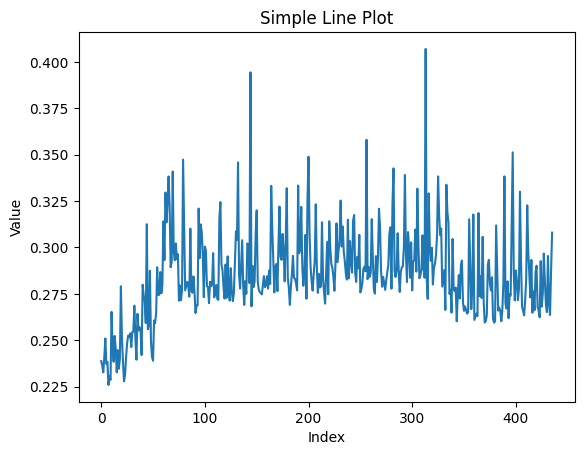

In [12]:
plt.plot(inf_time)

# Add titles and labels
plt.title('Simple Line Plot')
plt.xlabel('Index')
plt.ylabel('Value')

# Display the plot
plt.show()

In [13]:
np.mean(inf_time)*1000

285.1501621237589

In [14]:
len(inf_time)

436

In [15]:
patchtst_preds_copy = patchtst_preds


In [16]:
patchtst_preds.head()

unique_id                  ds   PatchTST
0        2.0 2013-09-20 20:45:00  33.924042
1        2.0 2013-09-20 20:50:00  32.777363
2        2.0 2013-09-20 20:55:00  32.425568
3        2.0 2013-09-20 21:00:00  34.522881
4        2.0 2013-09-20 21:05:00  34.832241

In [17]:
df2 = patchtst_preds[patchtst_preds['unique_id']==2]
df4 = patchtst_preds[patchtst_preds['unique_id']==4]
df6 = patchtst_preds[patchtst_preds['unique_id']==6]
df2.shape, df4.shape, df6.shape

((2616, 3), (2616, 3), (2616, 3))

In [18]:
patchtst_preds = patchtst_preds.sort_values(by=['ds', 'unique_id'])
patchtst_preds.set_index('ds', inplace=True)
patchtst_preds.reset_index(inplace=True)

In [19]:
patchtst_preds.head(12)

ds  unique_id   PatchTST
0  2013-09-20 20:45:00        2.0  33.924042
1  2013-09-20 20:45:00        4.0  22.243320
2  2013-09-20 20:45:00        6.0  47.356136
3  2013-09-20 20:50:00        2.0  32.777363
4  2013-09-20 20:50:00        4.0  25.526382
5  2013-09-20 20:50:00        6.0  39.931896
6  2013-09-20 20:55:00        2.0  32.425568
7  2013-09-20 20:55:00        4.0  19.500296
8  2013-09-20 20:55:00        6.0  46.123089
9  2013-09-20 21:00:00        2.0  34.522881
10 2013-09-20 21:00:00        4.0  20.888823
11 2013-09-20 21:00:00        6.0  39.563576

In [20]:
df_test = df_test.sort_values(by=['ds', 'unique_id'])
df_test.set_index('ds', inplace=True)
df_test.reset_index(inplace=True)
df_test.head(21)

ds  unique_id          y
0  2013-09-20 20:45:00        2.0  36.766667
1  2013-09-20 20:45:00        4.0  15.716667
2  2013-09-20 20:45:00        6.0  47.288889
3  2013-09-20 20:50:00        2.0  33.133333
4  2013-09-20 20:50:00        4.0  16.100000
5  2013-09-20 20:50:00        6.0  37.311111
6  2013-09-20 20:55:00        2.0  31.566667
7  2013-09-20 20:55:00        4.0  41.166667
8  2013-09-20 20:55:00        6.0  44.333333
9  2013-09-20 21:00:00        2.0  27.366667
10 2013-09-20 21:00:00        4.0  31.783333
11 2013-09-20 21:00:00        6.0  38.233333
12 2013-09-20 21:05:00        2.0  29.833333
13 2013-09-20 21:05:00        4.0  20.066667
14 2013-09-20 21:05:00        6.0  42.900000
15 2013-09-20 21:10:00        2.0  17.733333
16 2013-09-20 21:10:00        4.0  20.950000
17 2013-09-20 21:10:00        6.0  35.500000
18 2013-09-20 21:15:00        2.0  22.066667
19 2013-09-20 21:15:00        4.0  15.450000
20 2013-09-20 21:15:00        6.0  40.700000

In [21]:
patchtst_preds['cpu_real'] = df_test['y']
patchtst_preds

ds  unique_id   PatchTST   cpu_real
0    2013-09-20 20:45:00        2.0  33.924042  36.766667
1    2013-09-20 20:45:00        4.0  22.243320  15.716667
2    2013-09-20 20:45:00        6.0  47.356136  47.288889
3    2013-09-20 20:50:00        2.0  32.777363  33.133333
4    2013-09-20 20:50:00        4.0  25.526382  16.100000
...                  ...        ...        ...        ...
7843 2013-09-29 22:35:00        4.0  10.175591  12.583333
7844 2013-09-29 22:35:00        6.0  33.919270  33.933333
7845 2013-09-29 22:40:00        2.0  41.837189  20.800000
7846 2013-09-29 22:40:00        4.0  15.188745  26.116667
7847 2013-09-29 22:40:00        6.0  43.062988  44.500000

[7848 rows x 4 columns]

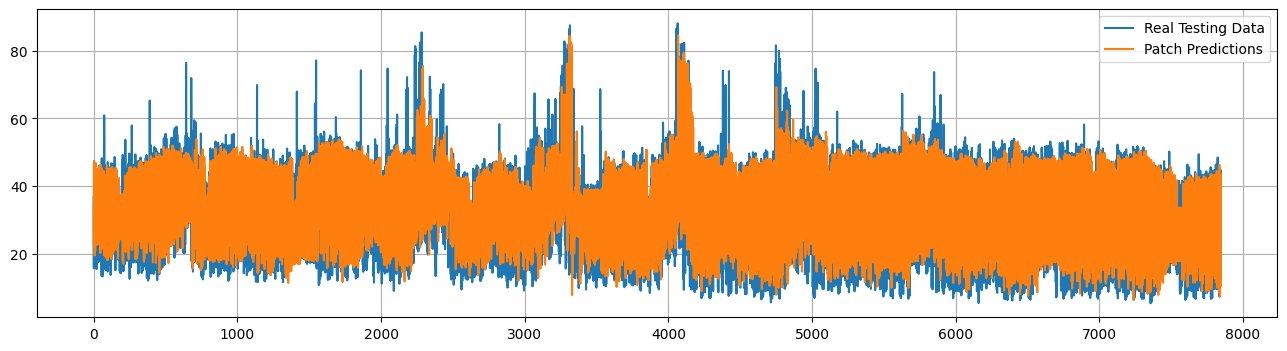

In [22]:
plt.figure(figsize=(16,4))
plt.plot(patchtst_preds.index[:], patchtst_preds['cpu_real'][:], label='Real Testing Data')
plt.plot(patchtst_preds.index[:], patchtst_preds['PatchTST'][:], label='Patch Predictions')
plt.grid()
plt.legend()
plt.show()

In [ ]:
# patchtst_preds = patchtst_preds[:2550]

In [23]:
patchtst_preds.shape, df_test.shape

((7848, 4), (7857, 3))

In [24]:
df2 = patchtst_preds[patchtst_preds['unique_id']==2]
df4 = patchtst_preds[patchtst_preds['unique_id']==4]
df6 = patchtst_preds[patchtst_preds['unique_id']==6]
df2.shape, df4.shape, df6.shape

((2616, 4), (2616, 4), (2616, 4))

In [25]:
df2.set_index('ds', inplace=True)
df4.set_index('ds', inplace=True)
df6.set_index('ds', inplace=True)

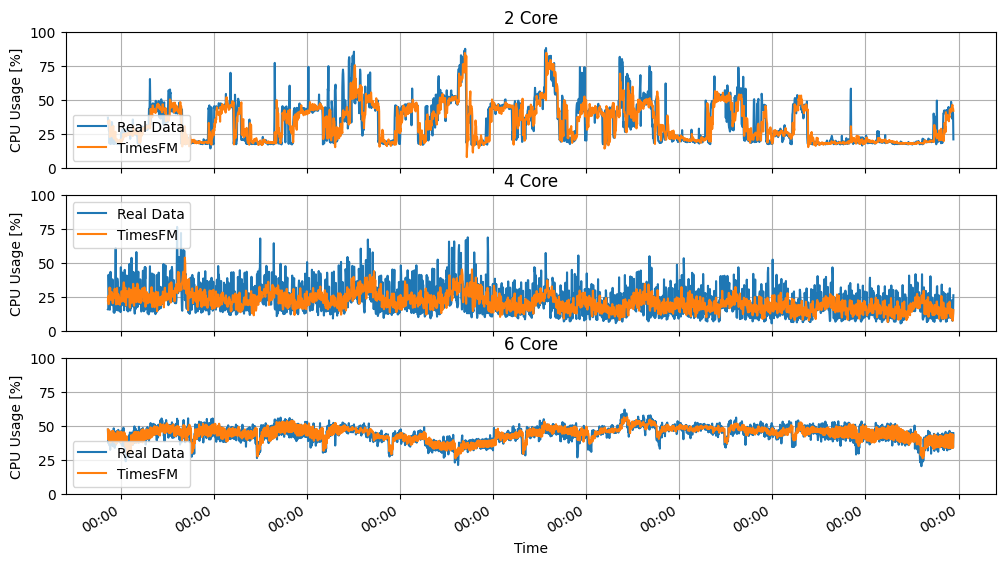

In [26]:
date = pd.to_datetime('2013-09-11 14:35:00')
fig, (ax1, ax2, ax3) = plt.subplots(ncols=1, nrows=3, figsize=(12,6), sharex=True)

ax1.plot(df2.index[:], df2['cpu_real'][:], label='Real Data')
ax1.plot(df2.index[:], df2['PatchTST'][:], label='TimesFM')
#ax1.plot(df2.index, df2['bi_lstm'], label='Bi-LSTM')
#ax1.plot(df2.index, df2['lstm'], label='LSTM')
#ax1.set_xlabel('Time')
ax1.set_ylabel('CPU Usage [%]')
ax1.set_ylim([0,100])
ax1.grid()
ax1.set_title('2 Core')
ax1.legend(loc='lower left')

ax2.plot(df4.index[:], df4['cpu_real'][:], label='Real Data')
ax2.plot(df4.index[:], df4['PatchTST'][:], label='TimesFM')
#ax2.plot(df4.index[210:300], df4['bi_lstm'][210:300], label='Bi-LSTM')
#ax2.plot(df4.index[210:300], df4['lstm'][210:300], label='LSTM')

#ax2.set_xlabel('Time')
ax2.set_ylabel('CPU Usage [%]')
ax2.grid()
ax2.set_ylim([0,100])
ax2.set_title('4 Core')
ax2.legend(loc='upper left')

ax3.plot(df6.index[:], df6['cpu_real'][:], label='Real Data')
ax3.plot(df6.index[:], df6['PatchTST'][:], label='TimesFM')
#ax3.plot(df6.index[210:300], df6['bi_lstm'][210:300], label='Bi-LSTM')
#ax3.plot(df6.index[210:300], df6['lstm'][210:300], label='LSTM')

ax3.set_xlabel('Time')
ax3.set_ylabel('CPU Usage [%]')
ax3.grid()
ax3.set_ylim([0,100])
ax3.set_title('6 Core')
ax3.legend(loc='lower left')
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

plt.setp(ax3.get_xticklabels(), rotation=30, ha='right')
#plt.savefig('models_bi_lstm_times.pdf', format='pdf')
plt.show()

In [27]:
def rmse(df):

    squared_diff = np.square(np.array(df['cpu_real']) - np.array(df['PatchTST']))

    # Calculate mean squared difference
    mse = np.mean(squared_diff)

    # Calculate RMSE
    rmse = np.sqrt(mse)

    return rmse

print(f"Root Mean Squared Error (RMSE): {rmse(patchtst_preds)}")

Root Mean Squared Error (RMSE): 8.512035854883052


In [ ]:
def calculate_mae(df):
    mae = mean_absolute_error(df['cpu_real'], df['PatchTST'])
    return mae

print(f"Mean Absolute Error (MAE): {calculate_mae(patchtst_preds)}")

Mean Absolute Error (MAE): 5.623852429763885


In [ ]:
r2_score(patchtst_preds['cpu_real'], patchtst_preds['PatchTST'])

0.6656183801753411

In [ ]:
torch.save(model.state_dict(), 'models/patchtst_model.pth')